
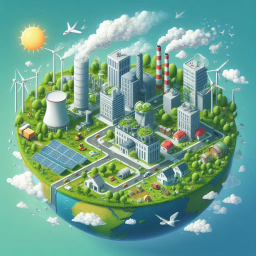 


# Project ML-Machine learning:
## Environmental social responsability in Aragon RSA 2025
### Jose Luis Padilla Villanova     (Abril 2025)

#### 0. Import neccesary libraries:

In [270]:
import sys
sys.path.append("../utils/")
import bootcampviztools as bt
import fitz  
import gower
import json
from opencage.geocoder import OpenCageGeocode
import matplotlib.pyplot as plt
import numpy as np
import nltk
import os
import pandas as pd
import pickle 
import re
import requests
import seaborn as sns
import sys
sys.path.append("../utils/")
import tensorflow_hub as hub
import time
import unicodedata
from PyPDF2 import PdfReader
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import linkage, fcluster
from itertools import combinations
from opencage.geocoder import OpenCageGeocode
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
pd.set_option("display.max_colwidth", None)  
pd.set_option("display.max_rows", None)  

#### 1. Business problem

A company specializing in environmental business consulting wants to compile a list of potential clients for its marketing department at its headquarters in Aragon.

The annual call for applications for the 2025 Aragon Social Responsibility Seal is a recognition for companies in Aragon. It publishes details of the entities that have earned it on its freely accessible website. In addition, a form is available, filled out by the company, which includes both its contact information and relevant data to determine if the entity could be a future client of our services.

Based on these 1,573 entities and the information provided, we propose identifying a group of entities that fit the profile of an entity interested in the environment and with improvement needs that we can cover with our services. 

#### 2. Technical problem and how it helps solve the business problem

We plan to extract the most interesting data for the company from the forms with web scraping using beatifulsoup. We will process the data to perform a hierarchical clustering analysis.

The advantage is that this analysis is interpretable and works well with small data sets.

We are working on an unsupervised learning problem; we don't have labels from previous experience to compare results. We will group the data, analyze the clusters obtained, and choose the most appropriate one. However, the marketing department will later confirm the validity of the results provided with the sales success on the provided list.

#### 3. Extraction of initial data. Web scraping (BeautiSoup) and requests

In [271]:
# We analyze the web page from which we want to extract the data:
url = "https://www.aragonempresa.com/empresas-sello-rsa/"
response = requests.get(url)
soup = BeautifulSoup(response.text, "lxml")

In [272]:
# We confirm successful connection:
if response.status_code == 200:
    print("Connection ok!")
else:
    print(f"Error: {response.status_code}")


Connection ok!


##### 3.1 Inspección web

In [273]:
# Display the HTML content of the web page in a more structured and readable format.
# This is especially useful for inspecting the page structure and locating the tags and classes needed to extract specific data.
# We see the rendered HTML with clear indentation, making it easier to identify elements such as <html>, <head>, or any other tag on the web page.
# Since the content is too long to view in the terminal, we redirect it to a text file for more convenient analysis:

# Set the path and file name to the desired folder.
ruta = "../utils/pagina_pretty.html"

with open(ruta, "w", encoding="utf-8") as file:
    file.write(soup.prettify())

print("File saved in:", ruta)

File saved in: ../utils/pagina_pretty.html


In [274]:
# We detect where the data we want to extract is stored:
# <a href="imprimir.php?idusuario=987&amp;idencuesta=4" class="btn btn-default" target="_blank"><img src="../img/iconosanexos/icon_pdf.png" style="height:22px;">&nbsp;&nbsp;RSA Questionnaire - AUTONOMOS-AS</a>
# We identify that the PDF document for each entity is composed of the following string:
# imprimir.php?idusuario=987&amp;idencuesta=4
# where the number 987 is the company ID and the number 4 is the questionnaire ID, since there are 4 types of questionnaires.
# So we can extract the data for each company with the following code:
for seccion in soup.find_all("a", href=True):
    if "imprimir.php" in seccion['href']:
        print(seccion['href'])

imprimir.php?idusuario=3125&idencuesta=4
imprimir.php?idusuario=1727&idencuesta=4
imprimir.php?idusuario=3541&idencuesta=4
imprimir.php?idusuario=1289&idencuesta=4
imprimir.php?idusuario=3192&idencuesta=4
imprimir.php?idusuario=1095&idencuesta=4
imprimir.php?idusuario=2759&idencuesta=4
imprimir.php?idusuario=696&idencuesta=4
imprimir.php?idusuario=2331&idencuesta=4
imprimir.php?idusuario=2119&idencuesta=4
imprimir.php?idusuario=536&idencuesta=4
imprimir.php?idusuario=2097&idencuesta=4
imprimir.php?idusuario=3234&idencuesta=4
imprimir.php?idusuario=1410&idencuesta=4
imprimir.php?idusuario=965&idencuesta=4
imprimir.php?idusuario=1754&idencuesta=4
imprimir.php?idusuario=1065&idencuesta=4
imprimir.php?idusuario=651&idencuesta=4
imprimir.php?idusuario=987&idencuesta=4
imprimir.php?idusuario=3446&idencuesta=4


In [275]:
# The page has a page selector, so we can iterate through all the pages to extract all the data:
# It has a fixed structure of 20 elements per page, so we can iterate 20 at a time to extract all the data.
# We create an empty list to store the company ID and questionnaire data so we can download the PDFs.

lista_id = []

for i in range(0, 1580, 20):
    url = f"https://www.aragonempresa.com/empresas-sello-rsa/?start={i}&count=20"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "lxml")
    for seccion in soup.find_all("a", href=True):
        if "imprimir.php" in seccion['href']:
            match_usuario = re.search(r'idusuario=(\d+)&', seccion['href'])
            match_encuesta = re.search(r'idencuesta=(\d+)', seccion['href'])
            if match_usuario and match_encuesta:
                lista_id.append((match_usuario.group(1), match_encuesta.group(1)))

In [276]:
# We have a list with client_id and form_id, two variables required to call
# the specific web address of each company form to download the PDF form.
# We sort by client_id
lista_id.sort()
# Example of the first element of our list
lista_id[0]

('1000', '7')

##### 3.2 PDF Form Download, Data Extraction, and Verification Process (Run Locally Only)
It is recommended not to run this section on GitHub, as it generates large files.
I've provided the code and data extraction verifications for the four types of forms.
We generate the initial data frame (df_0), which we save and can load

In [277]:
# Directory where we save the PDF forms, it is a folder that we do not upload to the repository due to its size
carpeta_destino = r"..\data_ignore\EDA"

# we make sure the destination folder exists
os.makedirs(carpeta_destino, exist_ok=True)

for i, j in lista_id:
    # Build the full path of the file
    ruta_archivo = os.path.join(carpeta_destino, f"empresa_sello_rsa_{i}_{j}.pdf")

    # Check if the file already exists
    if not os.path.exists(ruta_archivo):
        pdf_url = f"https://www.aragonempresa.com/empresas-sello-rsa/imprimir.php?idusuario={i}&idencuesta={j}"
        response = requests.get(pdf_url)
        with open(ruta_archivo, "wb") as file:
            file.write(response.content)
        print(f"Downloaded and saved {ruta_archivo}")
    else:
        print(f"File {ruta_archivo} already exists, skipping download.")

File ..\data_ignore\EDA\empresa_sello_rsa_1000_7.pdf already exists, skipping download.
File ..\data_ignore\EDA\empresa_sello_rsa_1001_6.pdf already exists, skipping download.
File ..\data_ignore\EDA\empresa_sello_rsa_1002_6.pdf already exists, skipping download.
File ..\data_ignore\EDA\empresa_sello_rsa_1004_9.pdf already exists, skipping download.
File ..\data_ignore\EDA\empresa_sello_rsa_1005_6.pdf already exists, skipping download.
File ..\data_ignore\EDA\empresa_sello_rsa_1009_6.pdf already exists, skipping download.
File ..\data_ignore\EDA\empresa_sello_rsa_1010_6.pdf already exists, skipping download.
File ..\data_ignore\EDA\empresa_sello_rsa_1011_6.pdf already exists, skipping download.
File ..\data_ignore\EDA\empresa_sello_rsa_1013_6.pdf already exists, skipping download.
File ..\data_ignore\EDA\empresa_sello_rsa_1014_6.pdf already exists, skipping download.
File ..\data_ignore\EDA\empresa_sello_rsa_1015_6.pdf already exists, skipping download.
File ..\data_ignore\EDA\empresa_

Analyzing the downloaded PDF forms, we found four types of forms.

Business considers the following relevant variables, which are common to all four, with nuances that we will need to take into account when determining the patterns:


| Variable                  | Type   | Description |
|---------------------------|--------|-------------|
| id_client (id_cliente)                | num    | Client identification |
| id_form  (id_formulario)                 | num.pdf| Identifies the 4 types of forms, check that the chosen fields were correctly detected. |
| organization_type (tipo_organizacion)        | object | Self-employed (120), Small business (850), Medium business (124), Large company (113), Public company (18), Entities (301), NGOs (47) |
| organization_name (nombre_organizacion)        | object | Anonymize, we will use id_client |
| address (direccion)                  | object | Convert to latitude and longitude for geolocation on a map |
| activity_sector   (sector_actividad)        | object | Analyze, important variable for grouping, it is in natural language, it is interesting to relate it to pollution level: Most_polluting/Normal/Less_polluting (ecological sectors, waste management) |
| year                     | object | Year of start of activity |
| contact_person  (persona_contacto)           | object | Name of the responsible person. Anonymize, will be used in the commercial contact phase |
| contact_email  (email_contacto)           | object | Contact email. Anonymize, will be used in the commercial contact phase |
| website     (pagina_web)              | object | Anonymize. Only useful for deepening the commercial department to tailor the service offer and get to know the client. |
| activity_impact (impacto_actividad)          | object | It is natural language and reflects the client's assessment of the environmental impact of their activity |
| environmental_priority (prioridad_mediambiental)   | num    | The entity prioritizes the importance it gives to the following aspects to achieve success, focusing only on the importance given to "Working to protect and improve the environment" in socially responsible management. (1 most important - 10 least important) Options: |
||| Employ open and transparent business practices |
||| Manage with exemplarity |
||| Listen to the needs and expectations of stakeholders |
||| Implement responsible practices in Human Resources management |
||| Offer quality products and services |
||| Training and professional development |
||| Have a budget |
||| Work to protect and improve the environment |
||| Create programs with a positive impact on the local community |
||| Be a profitable and sustainable business over time |
| improvement  (mejora)             | object | To the questionnaire question "Could you state an area for improvement?" It is natural language, and the business considers it interesting to study to detect needs in the entity, understanding that if there are no improvements, it is difficult to offer our services. |


PyMuPDF is a Python module that is part of the PyMuPDF library, which is used to interact and work with PDF documents.
It is especially useful for tasks related to PDF extraction, editing, and manipulation.

We use the following function to extract the selected data, keeping in mind that we have four forms and need to include different options.


In [278]:
def extraer_datos(pdf_path):
    datos = {}

    with fitz.open(pdf_path) as pdf:
        texto_completo = ""

        # Concatenate all text from the PDF pages
        for page_num in range(len(pdf)):
            texto_completo += pdf[page_num].get_text()

        # Pattern to remove page skirts (ej. "[...] página X/XX")
        patron_faldon = r'''\[-\d+\]
        \s*RSA\s-\s    
        (Entidades\sno\slucrativas|GRANDES\sEMPRESAS\sY\sEMPRESAS\sPÚBLICAS|AUTONOMOS-AS|PYMES)?  
        \s*página\s\d+/\d+\n?  
        '''
        # Remove footnotes from the entire text
        texto_sin_faldon = re.sub(patron_faldon, '', texto_completo, flags=re.VERBOSE | re.DOTALL)


        # ID del cliente y id_formulario
        datos["id_cliente"] = pdf_path.split("_")[-2]
        datos["id_formulario"] = pdf_path.split("_")[-1]

        # Tipo de organización
        patron_tipo = r"\n*RSA - (.*?)\n*Empresa evaluada"
        match_tipo = re.search(patron_tipo, texto_sin_faldon, re.DOTALL)
        if match_tipo:
            datos['tipo_organizacion'] = match_tipo.group(1).replace("\n", " ").strip()

        # Denominación de la organización
        patron_nombre = r"(\d{2} - )?Denominación de la organización\n(.*?)\n(02 - Dirección - CP - Población)?(Forma jurídica)?"
        match_nombre = re.search(patron_nombre, texto_sin_faldon, re.DOTALL | re.IGNORECASE)
        if match_nombre:
            datos['nombre_organizacion'] = match_nombre.group(2).replace("\n", " ").strip()

        # Dirección
        patron_direccion = r"(\d{2} - )?Dirección - CP - Poblaci[oó]n\n(.*?)(\d{2} - )?Sector(. Actividad)?(/Ámbito de actuación.)?"
        match_direccion = re.search(patron_direccion, texto_sin_faldon, re.DOTALL | re.IGNORECASE)
        if match_direccion:
            datos['direccion'] = match_direccion.group(2).replace("\n", " ").strip()

        # Sector y actividad principal
        patron_sector = r'\b(?:Sector(?:\. Actividad)?(?:/Ámbito de actuación\.)?|03 - Sector\. Actividad)\s*\n(.*?)(?=\n(?:Actividad principal|04 - Año comienzo actividad))'
        match_sector = re.search(patron_sector, texto_sin_faldon, re.DOTALL)
        if match_sector:
            datos['sector_actividad'] = match_sector.group(1).replace("\n", " ").strip()

        # Año de comienzo de actividad
        patron_year = r'(04 - )?Año comienzo actividad\.\n(.*?)\n(05 - Persona de contacto)?(05 - Número de personas empleadas)?(Número de personas empleadas - media anual)?'
        match_year = re.search(patron_year, texto_sin_faldon, re.DOTALL | re.IGNORECASE)
        if match_year:
            datos['year'] = match_year.group(2).strip()  # Captura el año (2016)
        
        # Número de personas empleadas
        patron_empleados = (
            r'(05 - )?Número de personas empleadas( - media anual)?\n'  # Inicio del bloque
            r'(.*?)(?=(06 - Persona contacto|Número de personas empleadas estables \(contrato indefinido\)|$))'  # Capturar todo hasta antes del siguiente bloque o el final
            )
        # Buscar coincidencia
        match_empleados = re.search(patron_empleados, texto_sin_faldon, re.DOTALL | re.IGNORECASE)
        if match_empleados:
            datos["empleados"] = match_empleados.group(3).strip()  # Captura todo el bloque intermedio

        # Persona de contacto
        patron_persona_contacto = r'\n(\d{2} - )?Persona (de )?contacto\n(.*?)\n(\d{2})?(E-mail contacto)?'
        match_persona_contacto = re.search(patron_persona_contacto, texto_sin_faldon, re.DOTALL | re.IGNORECASE)
        if match_persona_contacto:
            datos['persona_contacto'] = match_persona_contacto.group(3).replace("\n", " ").strip()

        # E-mail de contacto
        patron_email_contacto = r'\n(\d{2} - )?e-mail (persona )?contacto:?\n(.*?)\n(\d{2}.- )?Página web'
        match_email_contacto = re.search(patron_email_contacto, texto_sin_faldon, re.DOTALL | re.IGNORECASE)
        if match_email_contacto:
            datos['email_contacto'] = match_email_contacto.group(3).replace("\n", " ").strip()

        # Página web
        patron_pagina_web = r'\n(\d{2}.- )?Página web\n(.*?)\n*GENERAL'
        match_pagina_web = re.search(patron_pagina_web, texto_sin_faldon, re.DOTALL)
        if match_pagina_web:
            datos['pagina_web'] = match_pagina_web.group(2).replace("\n", " ").strip()

        # Impacto ambiental
        patron_impacto_actividad = r'(impacto )?ambiental en el desarrollo de la actividad\?\s*([\s\S]*?)\s*(?=Economía circular( y comunicación)?)'
        # Búsqueda en el texto
        match_impacto_actividad = re.search(patron_impacto_actividad, texto_sin_faldon, re.DOTALL)

        if match_impacto_actividad:
            datos["impacto_actividad"] = match_impacto_actividad.group(2).replace("\n", " ").strip()
    
        # Prioridad medioambiental
        patron_prioridad_medioambiental = r"(\d+) - Trabajar para proteger y mejorar el medio ambiente"
        match_prioridad_ma = re.search(patron_prioridad_medioambiental, texto_sin_faldon, re.DOTALL)
        if match_prioridad_ma:
            datos['prioridad mediambiental'] = match_prioridad_ma.group(1).strip()

        # Áreas de mejora
        patron_mejora = (
            r"\d+[.-]? ?-? ?¿Podría enunciar un [aá]rea de mejora\?\s*"
            r"((?:[^\n]*\n){1,20})"
            r"(?:\[-?\d+\] .*? página \d+/\d+\s*)?"
            r"\s*Agenda 2030 y Objetivos de Desarrollo Sostenible"
        )
        match_mejora = re.search(patron_mejora, texto_sin_faldon, re.DOTALL)
        if match_mejora:
            datos["mejora"] = " ".join(match_mejora.group(1).split())
    return datos


We created an individual example view in the four form formats to verify that it correctly captures all the fields:

In [279]:
pdf_path_4 = r"..\data_ignore\EDA\empresa_sello_rsa_1037_4.pdf"
datos_4 = extraer_datos(pdf_path_4)
df4 = pd.DataFrame([datos_4])   
print(df4.T.to_string())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           0
id_cliente                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [280]:
pdf_path_6 = r"..\data_ignore\EDA\empresa_sello_rsa_2505_6.pdf"
datos_6 = extraer_datos(pdf_path_6)
df6 = pd.DataFrame([datos_6])   
print(df6.T.to_string())

In [281]:
pdf_path_7 = r"..\data_ignore\EDA\empresa_sello_rsa_2448_7.pdf"
datos_7 = extraer_datos(pdf_path_7)
df7 = pd.DataFrame([datos_7])   
print(df7.T.to_string())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             0
id_cliente                                                                                                                                                                                                                                                                                                                                                                                               

In [282]:
pdf_path_9 = r"..\data_ignore\EDA\empresa_sello_rsa_2608_9.pdf"
datos_9 = extraer_datos(pdf_path_9)
df9 = pd.DataFrame([datos_9])   
print(df9.T.to_string())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             0
id_cliente                                                                                                                                                                                                                                                                                                                                                               

To create our base dataframe we create a previous dictionary

In [283]:
diccionario_id = {usuario_id: encuesta_id for usuario_id, encuesta_id in lista_id}

In [284]:

# Initialize the DataFrame with the appropriate columns and apply our extract function to 
# each of the downloaded PDF forms:
df_base = pd.DataFrame()

keys = list(diccionario_id.keys())
values = list(diccionario_id.values())

for i in range(len(diccionario_id)):
    id_usuario = keys[i]
    id_formulario = values[i]
    pdf_path = f"..\\data_ignore\\EDA\\empresa_sello_rsa_{id_usuario}_{id_formulario}.pdf"
    datos = extraer_datos(pdf_path)
    df_base = pd.concat([df_base, pd.DataFrame([datos], index=[id_usuario])], ignore_index=False)

df_base.head()

id_cliente id_formulario                     tipo_organizacion  \
1000       1000         7.pdf  GRANDES EMPRESAS Y EMPRESAS PÚBLICAS   
1001       1001         6.pdf                                 PYMES   
1002       1002         6.pdf                                 PYMES   
1004       1004         9.pdf               Entidades no lucrativas   
1005       1005         6.pdf                                 PYMES   

                                     nombre_organizacion  \
1000                                EL CORTE INGLÉS S.A.   
1001                                  AYANET RRHH, S..L.   
1002  IMPROVING, CONSULTORIA Y FORMACION, S.L. (IMFORMA)   
1004                                       ACISJF IN VIA   
1005                            ELECTRICIDAD AMARO, S.A.   

                                                             direccion  \
1000                                 C/Hermosilla, nº 112 28009 Madrid   
1001  Calle Bari 57, Edificio TIC XXI (Plaza) 50.197, Zaragoza, España   
1002                    AVENIDA DE LA JACETANIA, 21, 22700 JACA HUESCA   
1004                Paseo Echegaray y Caballero, 118, 50002 (Zaragoza)   
1005             Carretera del aeropuerto, km. 5,300 50.190 - ZARAGOZA   

                                                                                sector_actividad  \
1000                                                          Sector comercio, grandes almacenes   
1001  Consultoría integral de Recursos Humanos: - Selección - Formación - Consultoría y coaching   
1002                                                                    FORMACION PARA EL EMPLEO   
1004                                                                         Mujer/Acción Social   
1005                                                        Instalaciones eléctricas en general.   

                     year         empleados  \
1000                 1941  81.714  personas   
1001                 1985                 8   
1002                 2010                 7   
1004  En Zaragoza en 1953                 8   
1005                 1982                 4   

                                     persona_contacto  \
1000                           Isabel Paricio Perales   
1001                                Tania Grande Maza   
1002                            ISABEL VITALLÉ ZAURIN   
1004  María Jesús Soler Cochi. Directora de Programas   
1005                               Óscar Amaro Arceiz   

                       email_contacto              pagina_web  \
1000  isabel_paricio@elcorteingles.es    www.elcorteingles.es   
1001                tgrande@ayanet.es           www.ayanet.es   
1002           IVITALLE@EIMPROVING.ES          WWW.IMFORMA.ES   
1004         acisjfzaragoza@gmail.com  www.acisjfzaragoza.org   
1005                 oscar@eamaro.com          www.eamaro.com   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [285]:
# We save the dataframe in a csv file in the data_sample folder
df_base.to_csv(r"..\data_sample\datos_rsa.csv")

##### 3.3 We load our saved base file

In [286]:
df_base = pd.read_csv("../data_sample/datos_rsa.csv")

#### 4. Initial data cleaning 

We review the df_base data to correct, if possible, any gaps, errors, and anonymization process

In [287]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               1573 non-null   int64  
 1   id_cliente               1573 non-null   int64  
 2   id_formulario            1573 non-null   object 
 3   tipo_organizacion        1573 non-null   object 
 4   nombre_organizacion      1573 non-null   object 
 5   direccion                1573 non-null   object 
 6   sector_actividad         1571 non-null   object 
 7   year                     1573 non-null   object 
 8   empleados                1456 non-null   object 
 9   persona_contacto         1544 non-null   object 
 10  email_contacto           1563 non-null   object 
 11  pagina_web               1568 non-null   object 
 12  impacto_actividad        1573 non-null   object 
 13  prioridad mediambiental  1568 non-null   float64
 14  mejora                  

| Variable                  | Type   | Description | Action |
|---------------------------|--------|-------------|-------|
| Unnamed:0                 | int    | Automatic, duplicate of id_cliente | Delete |
| id_cliente                | num    | Client identification | Keep, base for anonymization |
| id_formulario             | object | Form type, only used for printing | Not useful |
| tipo_organizacion         | object | Self-employed (120), Small business (850), Medium business (124), Large company (113), Public company (18), Entities (301), NGOs (47) | Keep |
| nombre_organizacion       | object | Client name | Anonymize, we will use id_cliente |
| direccion                 | object | Client address | Convert to latitude and longitude for geolocation on a map |
| sector_actividad          | object | Activity sector | Analyze, important variable for grouping, it is in natural language, it is interesting to relate it to pollution level: Most_polluting/Normal/Less_polluting (ecological sectors, waste management) |
| year                      | object | Year of creation | Not considered interesting to convert to datetime, review because there may be different formats yyyy, dd/mm/yyyy... |
| empleados                 | object | Number of employees | In natural language, needs to be reviewed |
| persona_contacto          | object | Name of the responsible person | Anonymize, will be used in the commercial contact phase |
| email_contacto            | object | Contact email | Anonymize, will be used in the commercial contact phase |
| pagina_web                | object | Client website | Anonymize. Only useful for deepening the commercial department to tailor the service offer and get to know the client. Something is missing |
| impacto_actividad         | object | It is natural language and reflects the client's assessment of the environmental impact of their activity | Count relevant words as an indicator of significant environmental activity; a higher number suggests a greater environmental impact |
| prioridad mediambiental   | float  | The entity prioritizes the importance given to "Working to protect and improve the environment" in socially responsible management (1 most important - 10 least important) | Convert to int |
| mejora                    | object | To the questionnaire question "Could you state an area for improvement?" It is in natural language and the business considers it interesting to study to detect needs in the entity, understanding that if no improvements are detected, it is likely that the company is less open to hiring our services | Count relevant words as an indicator of the need for advice; if the company does not identify areas for improvement, it is less open to our services. |

In [288]:
df_limpio = df_base.drop(columns="Unnamed: 0")

In [289]:
df_limpio["id_formulario"].value_counts()
# This variable does not provide relevant information for the analysis, 
# only for viewing company files

id_formulario
6.pdf    973
9.pdf    350
7.pdf    133
4.pdf    117
Name: count, dtype: int64

<Axes: >

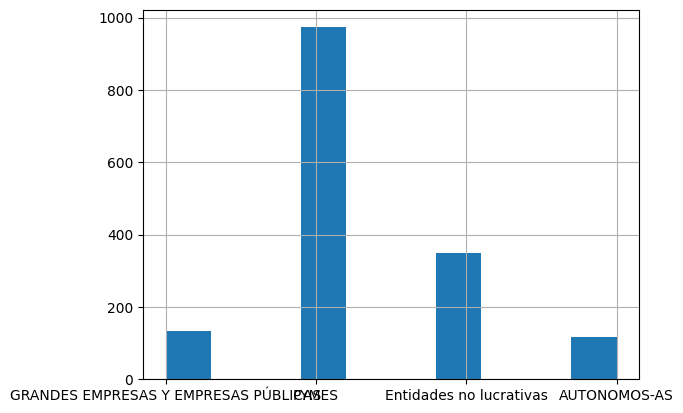

In [290]:
# Distribution of types of organizations
df_limpio["tipo_organizacion"].hist() 

In [291]:
df_limpio["nombre_organizacion"].value_counts()

nombre_organizacion
Sin respuesta                                                                                   3
GRUPO ARAMARK                                                                                   2
CONNEXA SOSTENIBILIDAD Y DIGITALIZACIÓN S.L.                                                    2
EL CORTE INGLÉS S.A.                                                                            1
BARNIZADOS BARME S.L.                                                                           1
MINTAKELLER SL                                                                                  1
Calderería y Silos Metaga, S.L.                                                                 1
Exportadora Turolense S.L.                                                                      1
Nombre comercial: Mas la Llum                                                                   1
Cualimetal S.A.U,  ofrece diseño, fabricación y montaje propio, desde construcciones            1


In [292]:
#We detected 3 "No Response" records "Sin respuesta"
df_limpio[df_limpio["nombre_organizacion"] == "Sin respuesta"]

,id_cliente,id_formulario,tipo_organizacion,nombre_organizacion,direccion,sector_actividad,year,empleados,persona_contacto,email_contacto,pagina_web,impacto_actividad,prioridad mediambiental,mejora
425,1827,7.pdf,GRANDES EMPRESAS Y EMPRESAS PÚBLICAS,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta 32.1. Información adicional Sin respuesta Compromiso frente al cambio climático 33.- ¿Se participa o se ponen en marcha acciones que evidencien el compromiso público de la organización para prevenir la contaminación? Sin respuesta,NaN,Sin respuesta
956,3083,6.pdf,PYMES,Sin respuesta,CTRA. COGULLADA 8 50014-ZARAGOZA,DISTRIBUCION DE MATERIAL ELECCTRICO Y ELECTRONICO,1976,28,RAUL PINA,raulpina@elektraaragon.com,https://www.grupoelektra.es/es/el-grupo/empresa/elektra-aragon,"Se evalúa el impacto ambiental y se ha desarrollado un plan de acciones en materia ambiental global para toda la organización, que cuenta con objetivos e indicadores en seguimiento cuyo resultado se mide periódicamente. 29.1. Información adicional. Nuestra actividad tiene muy poco impacto medioambiental. Sin embargo estamos certificados con las ISO50001 y somos punto de recogida de luminarias, lámparas y equipos para su reciclaje Compromiso frente al cambio climático 30.- ¿Se participa o se ponen en marcha acciones que evidencien el compromiso público de la organización para prevenir la contaminación? Existe un compromiso público junto con un plan de acciones que se comunica interna y externamente. 30.1. Información adicional. Damos soporte en eficiencia energética, vehículo eléctrico y renovables. Además de nuestro certificación en la ISO 50001",8.0,Tener un plan concreto con un presupuesto asignado para desarrollar nuestro RSC
1521,92,7.pdf,GRANDES EMPRESAS Y EMPRESAS PÚBLICAS,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta 32.1. Información adicional Sin respuesta Compromiso frente al cambio climático 33.- ¿Se participa o se ponen en marcha acciones que evidencien el compromiso público de la organización para prevenir la contaminación? Sin respuesta,NaN,Sin respuesta


In [293]:

# line 92 with incorrect forms from company 1827 form 6, so we delete them:
indices_to_drop = [1521,425]
df_limpio.drop(index=indices_to_drop, inplace=True)

# Line 3083 doesn't have the organization name filled in, but looking at the form, we see that it's ELEKTRA ARAGÓN XXI, S.L., so we fill it in manually:
df_limpio.loc[956, "nombre_organizacion"] = "ELEKTRA ARAGÓN XXI, S.L."

In [294]:
df_limpio[df_limpio["direccion"] == "Sin respuesta"]

,id_cliente,id_formulario,tipo_organizacion,nombre_organizacion,direccion,sector_actividad,year,empleados,persona_contacto,email_contacto,pagina_web,impacto_actividad,prioridad mediambiental,mejora
1512,905,6.pdf,PYMES,"ZEUMAT, SL",Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta 29.1. Información adicional. Sin respuesta Compromiso frente al cambio climático 30.- ¿Se participa o se ponen en marcha acciones que evidencien el compromiso público de la organización para prevenir la contaminación? Sin respuesta 30.1. Información adicional. Sin respuesta,NaN,Sin respuesta


In [295]:

# Duplicate customer on line 905, the correct one is 911
df_limpio.drop(index=1512, inplace=True)


##### 4.1 Converting address to coordinates

In [296]:
# We use OpenCage to locate the latitude and longitude coordinates of the addresses
# We define a function that first checks if we already have the coordinates in our JSON notebook.
# If we have coordinates, it takes them from the notebook; otherwise, it uses the API.
# If there is no address, it tries the postal code, and as a last resort, it tells us the records that
# either it has not located or do not have the postal code.


#key = 'c8631658aa1d4f688649d97490bfdb23'
key = '868719c58b7843de8591665f0e53848f'
geocoder = OpenCageGeocode(key)

# File path where the results are saved
cache_file = '../utils/geocoding_cache.json' 

def geocode_addresses(df, key, cache_file):
    geocoder = OpenCageGeocode(key)

    # Load existing cache
    if os.path.exists(cache_file):
        with open(cache_file, "r") as f:
            cache = json.load(f)
    else:
        cache = {}

    # Initialize latitude and longitude columns
    df["latitud"] = None
    df["longitud"] = None

    for i in df_limpio.index:
        try:
            # Check if the address is valid
            query = str(df.loc[i, "direccion"])
            if pd.isnull(query) or query.strip() == "":
                print(f"Dirección vacía para id_cliente: {df.loc[i, 'id_cliente']}")
                continue

            # Check cache for full address
            if query in cache:
                df.at[i, "latitud"] = cache[query]["lat"]
                df.at[i, "longitud"] = cache[query]["lng"]
                continue

            # Query OpenCage
            results = geocoder.geocode(query)
            if results:
                lat = results[0]["geometry"]["lat"]
                lng = results[0]["geometry"]["lng"]
                df.at[i, "latitud"] = lat
                df.at[i, "longitud"] = lng
                cache[query] = {"lat": lat, "lng": lng}
                continue

            # If there are no results, try the postal code
            match = re.search(r"\b(50\d{3}|22\d{3}|44\d{3})\b", query)
            if match:
                postal_code = match.group(0)
                query_postal = f"{postal_code}, Spain"

                if query_postal in cache:
                    df.at[i, "latitud"] = cache[query_postal]["lat"]
                    df.at[i, "longitud"] = cache[query_postal]["lng"]
                else:
                    results_postal = geocoder.geocode(query_postal)
                    if results_postal:
                        lat = results_postal[0]["geometry"]["lat"]
                        lng = results_postal[0]["geometry"]["lng"]
                        df.at[i, "latitud"] = lat
                        df.at[i, "longitud"] = lng
                        cache[query_postal] = {"lat": lat, "lng": lng}
                    else:
                        print(f"No coordinates found: {df.loc[i, 'id_cliente']} - {query_postal}")
            else:
                print(f"Address without zip code: {df.loc[i, 'id_cliente']} - {query}")

            # Pause between queries to avoid speed limits
            time.sleep(1)

        except Exception as e:
            print(f"Error processing id_cliente {df.loc[i, 'id_cliente']}: {e}")

    # Save updated cache
    with open(cache_file, "w") as f:
        json.dump(cache, f, indent=4)

    return df

In [297]:
df_limpio = geocode_addresses(df_limpio, key, cache_file) 

# addresses not located due to missing data or postal code errors
# since there are 21 cases, they are searched manually and we will complete the JSON notebook with the postal codes to simplify


Address without zip code: 1226 - Parque Científico Tecnológico Aula Dei. Polígono Valdeferrín, Edificio EXION. Locales 5 - 6
Address without zip code: 1601 - Calle San Jorge, nº 7, pral.
Address without zip code: 1645 - C/ Barrioverde, nº 10, local  y C/ Blanca de Navarra 2, local
Address without zip code: 1674 - Plaza Cataluña oficinas
Address without zip code: 1744 - CALLE DEL PARQUE, 2. 3º DCHA.
Address without zip code: 2100 - CL JERONIMO ZURITA Nº17 ENTRESUELO DERECHA
Address without zip code: 2209 - C/ 7 de febrero de 1882, num 2 local PIRINEUM
Address without zip code: 2397 - PASEO ECHEGARAY Y CABALLERO 122, LOCAL
Address without zip code: 253 - Calle Río Duero 13 Local
Address without zip code: 2680 - Pol. Ind. Malpica, Calle D, Nº 65
Address without zip code: 2683 - Paseo Constitución 43 bajo derecho
Address without zip code: 2759 - As de Pisos  C/ San Ignacio de Loyola nº4 Local Zaragoza
Address without zip code: 2831 - CALLE LA ENCINA Nº4, 50.171 LA PUEBLA DE ALFINÉN (ZARAGO

In [298]:
# Dictionary with the id_cliente and their postal codes manually corrected
codigos_postales_correcciones = {
    1226: "50600",
    1601: "50001",
    1645: "50010",
    1674: "50001",
    1744: "22002",
    2100: "50001",
    2209: "22700",
    2397: "50001",
    253: "50003",
    2680: "50016",
    2683: "50001",
    2759: "50008", 
    2831: "50171",
    3032: "50001",
    3087: "44600",
    494: "50009",
    585: "22197",
    623: "44556",
    840: "50001",
    943: "50014",
    952: "50001"
}

# Manually add postal codes to the DataFrame
for id_cliente, codigo_postal in codigos_postales_correcciones.items():
    # Locate the row by the customer_id and assign the postal code manually
    if id_cliente in df_limpio["id_cliente"].values:
        df_limpio.loc[df_limpio["id_cliente"] == id_cliente, "direccion"] = codigo_postal

# Check the updated rows
print(df_limpio[df_limpio["id_cliente"].isin(codigos_postales_correcciones.keys())][["id_cliente", "direccion"]])


      id_cliente direccion
100         1226     50600
308         1601     50001
339         1645     50010
355         1674     50001
378         1744     22002
542         2100     50001
582         2209     22700
685         2397     50001
727          253     50003
765         2680     50016
768         2683     50001
813         2759     50008
850         2831     50171
925         3032     50001
959         3087     44600
1277         494     50009
1343         585     22197
1362         623     44556
1473         840     50001
1533         943     50014
1536         952     50001


In [299]:

# We apply the function again to locate the coordinates of the remaining 21 addresses
df_limpio = geocode_addresses(df_limpio, key, cache_file)

In [300]:
# Convert to float
df_limpio['long_num'] = pd.to_numeric(df_limpio['longitud'], errors='coerce').astype('float64')
df_limpio['latitud_num'] = pd.to_numeric(df_limpio['latitud'], errors='coerce').astype('float64')

In [301]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_cliente               1570 non-null   int64  
 1   id_formulario            1570 non-null   object 
 2   tipo_organizacion        1570 non-null   object 
 3   nombre_organizacion      1570 non-null   object 
 4   direccion                1570 non-null   object 
 5   sector_actividad         1568 non-null   object 
 6   year                     1570 non-null   object 
 7   empleados                1453 non-null   object 
 8   persona_contacto         1541 non-null   object 
 9   email_contacto           1560 non-null   object 
 10  pagina_web               1565 non-null   object 
 11  impacto_actividad        1570 non-null   object 
 12  prioridad mediambiental  1568 non-null   float64
 13  mejora                   1559 non-null   object 
 14  latitud                  1570

##### 4.2 Analysis of the variable: year 

It is a natural language variable that has been entered in the yyyy format but also with text, so we are going to locate the year, eliminate periods like 1989, for this we define a function that detects the first 4-digit year.

In [302]:
df_limpio["year"].value_counts(dropna="False").sort_values(ascending=False)

year
2014                                                                                            43
2019                                                                                            42
2016                                                                                            39
2007                                                                                            36
2013                                                                                            33
2002                                                                                            33
2017                                                                                            32
2018                                                                                            32
2015                                                                                            31
1997                                                                                            31
2005 

In [303]:
# Function to detect the first valid year in different formats
# Function to clean periods and extract the first 4-digit year
def detectar_year(texto):
    if not texto or not isinstance(texto, str):  
        return None
  
    texto_limpio = re.sub(r'(\d+)\.(\d+)', r'\1\2', texto)

    patron_year = r'\b(15\d{2}|16\d{2}|17\d{2}|18\d{2}|19\d{2}|20\d{2})\b'
    match = re.search(patron_year, texto_limpio)
    if match:
        return match.group(1)
    return None

In [304]:

df_limpio["year_2"] = df_limpio["year"].apply(detectar_year)

In [305]:

# We analyze the unique values ​​to detect if there are nulls:
valores_unicos = df_limpio["year_2"].astype(str).unique()
valores_erroneos = [y for y in valores_unicos if not re.fullmatch(r"\d{4}", str(y))]
valores_unicos

array(['1941', '1985', '2010', '1953', '1982', '1999', '1910', '1990',
       'None', '2018', '1958', '1975', '2016', '1995', '2009', '1964',
       '1997', '1977', '1993', '1996', '2015', '2013', '1944', '1962',
       '2004', '1991', '2014', '1989', '2006', '2005', '2003', '2001',
       '1983', '2000', '2017', '2011', '1998', '2007', '1981', '2012',
       '1966', '1929', '2008', '1961', '1984', '1965', '1952', '1946',
       '2002', '1992', '1956', '1986', '1979', '1954', '1967', '1974',
       '1980', '1963', '1968', '1978', '1723', '1925', '1969', '1876',
       '1988', '1927', '1987', '1899', '1905', '2019', '1994', '1931',
       '1912', '1900', '1948', '1934', '2023', '1886', '1971', '1957',
       '2020', '1960', '1945', '1903', '1950', '1935', '1972', '1940',
       '2022', '1973', '1874', '1959', '1943', '1947', '2021', '1955',
       '1976', '1870', '1951', '1922', '1926', '1852', '1868', '1970',
       '1949', '2024', '1933', '1828', '1915', '1918', '1881', '1907',
      

In [306]:
# Filter rows where 'year_2' has null values ​​(None or NaN)
resultado = df_limpio[df_limpio["year_2"].isna()][["id_cliente", "year", "year_2"]]

resultado

,id_cliente,year,year_2
9,1014,30/01/83,None
16,1051,HISTORIA,None
61,1156,"QUÍMICA DEL CINCA, S.L. es una empresa vinculada en el GRUPO SERUSAN,",None
103,1230,Nació como Asociación de Desarrollo Comunitario en Áreas de Aragón (ADCARA) el 24 de,None
186,136,T&Z Formación S.L. (System Zaragoza) inicia su actividad en Zaragoza en Septiembre de,None
205,1446,"Comenzó la actividad en la década de los 60, contamos con más de 50 años de",None
211,1457,La Sociedad Municipal Zaragoza Vivienda SLU. tiene su primer antecedente en el,None
256,1525,"La entidad tiene su origen bajo la denominación ASOCIACIÓN MANCALA, en Zaragoza,",None
303,1592,EL GRUPO EMPRESARIAL (INSTALACIONES LOPEZ) AL CUAL PERTENECE LA,None
357,169,Años de empresas anteriores:,None


In [307]:
# We created a manual dictionary with the date corrections for the 27 records
fechas_correcciones = {1014: '1983',
 1051: '2005',
 1156: '1980',
 1230: '1994',
 136: '1996',
 1446: '1960',
 1457: '1960',
 1525: '1955',
 1592: '1976',
 169: '1998',
 1955: None,
 2391: '1990',
 2874: '1994',
 3236: '2014',
 3324: '2019',
 3338: '1994',
 3417: '1948',
 346: '2007',
 3522: '2020',
 465: '1969',
 542: '1975',
 548: '1992',
 660: '1962',
 696: None,
 960: '2000'}

for id_cliente, fecha in fechas_correcciones.items():
   
    if id_cliente in df_limpio["id_cliente"].values:
        df_limpio.loc[df_limpio["id_cliente"] == id_cliente, "year_2"] = fecha


print(df_limpio[df_limpio["id_cliente"].isin(fechas_correcciones.keys())][["id_cliente", "year_2"]])

      id_cliente year_2
9           1014   1983
16          1051   2005
61          1156   1980
103         1230   1994
186          136   1996
205         1446   1960
211         1457   1960
256         1525   1955
303         1592   1976
357          169   1998
512         1955   None
680         2391   1990
870         2874   1994
1052        3236   2014
1084        3324   2019
1085        3338   1994
1109        3417   1948
1141         346   2007
1189        3522   2020
1258         465   1969
1316         542   1975
1320         548   1992
1382         660   1962
1400         696   None
1543         960   2000


In [308]:
# Convert non-numeric values ​​like "unknown" to NaN so they are ignored when calculating the mean
# Convert non-numeric values ​​to NaN to calculate the mean
df_limpio['year_2'] = pd.to_numeric(df_limpio['year_2'], errors='coerce')


media = df_limpio['year_2'].mean()


df_limpio['year_2'] = df_limpio['year_2'].fillna(media)

In [309]:
# Convert to int:
df_limpio['year_3'] = pd.to_numeric(df_limpio['year_2'], errors='coerce').astype('int')

In [310]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_cliente               1570 non-null   int64  
 1   id_formulario            1570 non-null   object 
 2   tipo_organizacion        1570 non-null   object 
 3   nombre_organizacion      1570 non-null   object 
 4   direccion                1570 non-null   object 
 5   sector_actividad         1568 non-null   object 
 6   year                     1570 non-null   object 
 7   empleados                1453 non-null   object 
 8   persona_contacto         1541 non-null   object 
 9   email_contacto           1560 non-null   object 
 10  pagina_web               1565 non-null   object 
 11  impacto_actividad        1570 non-null   object 
 12  prioridad mediambiental  1568 non-null   float64
 13  mejora                   1559 non-null   object 
 14  latitud                  1570

##### 4.3 Analysis of the variable: empleados 


We encounter numeric values ​​and text, it will be necessary to convert to numeric and check for errors.

In [311]:
# Función para detectar trabajadores
def detectar_trabajadores(texto):
    if not texto or not isinstance(texto, str):  # Validar que el valor no sea nulo o no sea cadena
        return None
    # Quitar puntos de los números, como transformar "1.996" en "1996"
    texto_limpio = re.sub(r'(\d+)\.(\d+)', r'\1\2', texto)
    # Patrón para encontrar el primer numero
    patron_trabajadores = r'\b(\d+)\b'
    match = re.search(patron_trabajadores, texto_limpio)
    # if match:
    #     return match.group(1)
    # return None
    numeros_encontrados = re.findall(patron_trabajadores, texto_limpio)
    return numeros_encontrados

In [312]:
# Crear la columna 'empleados_2' si no existe
if 'empleados_2' not in df_limpio.columns:
    df_limpio['empleados_2'] = None

for i in range(len(df_limpio)):
    if df_limpio.iloc[i]["tipo_organizacion"] == "AUTONOMOS-AS":
        df_limpio.iloc[i, df_limpio.columns.get_loc("empleados_2")] = 1
    else: 
        # Detectar el número de trabajadores usando la función y asignarlo a empleados_2
        trabajadores = detectar_trabajadores(df_limpio.iloc[i]["empleados"])
        if trabajadores:
            df_limpio.iloc[i, df_limpio.columns.get_loc("empleados_2")] = trabajadores[0]
        else:
            df_limpio.iloc[i, df_limpio.columns.get_loc("empleados_2")] = None

In [313]:
df_empleados_erroneos = df_limpio[df_limpio["empleados_2"].isnull()][["id_cliente", "empleados", "empleados_2"]]
df_empleados_erroneos

,id_cliente,empleados,empleados_2
9,1014,"Tres personas contratadas de continuo, subcontratacion según demanda de trabajo.",None
17,1054,EMPLEADAS : NINGUNA.\n.,None
69,1171,Dos personas de manera intermitente,None
133,1286,"Una persona empleada cotizando en régimen de artistas, se le contrata para las\nactuaciones, ensayos, etc. En ocasiones dos o tres personas contratadas, dependiendo de\nla necesidad de la producción.",None
161,1326,Seis,None
173,1343,"En estos momentos no existen personas empleadas directamente en la empresa, existen\ndiversos colaboradores habituales.",None
174,1344,"En la actualidad en nómina,solo tenemos un empleado",None
177,1348,Dos,None
183,1357,"Actualmente la Asociación cuenta con cinco trabajadoras; una trabajadora social, una\nmaestra en educación especial, una fisioterapeuta, una coordinadora y técnico\nadministrativo (persona con discapacidad física) y una psicóloga.",None
214,1461,EL PERSONAL ES VOLUNTARIO. ACTUALMENTE NO HAY EMPLEADOS,None


In [314]:
# Dictionary with the client and employee ids manually corrected, if not provided and not considered relevant it is set to 0
empleados_correcciones = {1014: '3',
 1054: '0',
 1171: '2',
 1286: '3',
 1326: '6',
 1343: '0',
 1344: '1',
 1348: '2',
 1357: '5',
 1461: '0',
 1462: '0',
 1495: '3',
 1586: '0',
 1644: '2',
 1658: '0',
 1729: '0',
 1779: '0',
 1782: '0',
 1840: '0',
 1864: '0',
 1884: '0',
 1907: '3',
 1919: '4',
 1923: '0',
 1951: '0',
 1952: '15',
 1971: '6',
 2126: '1',
 2129: '4',
 2233: '8',
 2291: '2',
 2315: '12',
 2392: '0',
 2678: '11',
 2703: '18',
 2706: '0',
 2708: '0',
 2820: '3',
 2915: '0',
 2921: '3',
 3007: '0',
 3050: '3',
 3068: '9',
 3087: '5',
 3107: '0',
 3111: '0',
 3114: '1',
 3151: '2',
 3157: '2',
 3158: '9',
 3165: '1',
 3201: '0',
 3230: '1',
 3256: '2',
 3396: '0',
 3411: '0',
 3429: '8',
 346: '14',
 3522: '5',
 461: '0',
 508: '0',
 559: '11',
 580: '20',
 639: '2',
 753: '0',
 906: '4',
 926: '5'}


for id_cliente, empleados in empleados_correcciones.items():
    
    if id_cliente in df_limpio["id_cliente"].values:
        df_limpio.loc[df_limpio["id_cliente"] == id_cliente, "empleados_2"] = empleados


print(df_limpio[df_limpio["id_cliente"].isin(empleados_correcciones.keys())][["id_cliente", "empleados_2"]])

      id_cliente empleados_2
9           1014           3
17          1054           0
69          1171           2
133         1286           3
161         1326           6
173         1343           0
174         1344           1
177         1348           2
183         1357           5
214         1461           0
215         1462           0
238         1495           3
299         1586           0
338         1644           2
346         1658           0
369         1729           0
397         1779           0
401         1782           0
435         1840           0
451         1864           0
464         1884           0
480         1907           3
488         1919           4
491         1923           0
508         1951           0
509         1952          15
521         1971           6
548         2126           1
551         2129           4
597         2233           8
630         2291           2
643         2315          12
681         2392           0
764         26

In [315]:
# convert to numeric:
df_limpio['empleados_2'] = pd.to_numeric(df_limpio['empleados_2'], errors='coerce').astype('Int64')

In [316]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_cliente               1570 non-null   int64  
 1   id_formulario            1570 non-null   object 
 2   tipo_organizacion        1570 non-null   object 
 3   nombre_organizacion      1570 non-null   object 
 4   direccion                1570 non-null   object 
 5   sector_actividad         1568 non-null   object 
 6   year                     1570 non-null   object 
 7   empleados                1453 non-null   object 
 8   persona_contacto         1541 non-null   object 
 9   email_contacto           1560 non-null   object 
 10  pagina_web               1565 non-null   object 
 11  impacto_actividad        1570 non-null   object 
 12  prioridad mediambiental  1568 non-null   float64
 13  mejora                   1559 non-null   object 
 14  latitud                  1570

##### 4.4 Analisys of the variable: prioridad mediambiental

In [317]:
df_limpio["prioridad mediambiental"].value_counts().sort_values()

#Prioritize the importance you give to the following aspects for achieving success in socially responsible management. (1 most important - 10 least important)
#Work to protect and improve the environment

prioridad mediambiental
1.0      42
2.0      53
3.0      70
4.0     106
5.0     117
6.0     144
7.0     213
10.0    218
8.0     265
9.0     340
Name: count, dtype: int64

<Axes: >

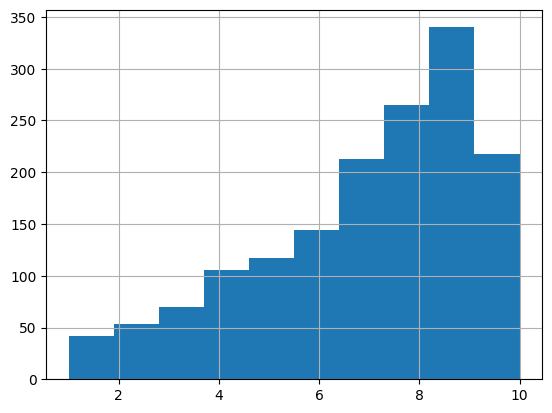

In [318]:
df_limpio["prioridad mediambiental"].hist()

In [319]:
df_limpio[df_limpio["prioridad mediambiental"].isnull()]

,id_cliente,id_formulario,tipo_organizacion,nombre_organizacion,direccion,sector_actividad,year,empleados,persona_contacto,email_contacto,...,impacto_actividad,prioridad mediambiental,mejora,latitud,longitud,long_num,latitud_num,year_2,year_3,empleados_2
507,1950,9.pdf,Entidades no lucrativas,Go Aragón,"Calle Dr. Horno Alcorta, 7, 50004 Zaragoza",Comunicación,2021,1,Alfredo Cortés Cubero,alfredo.cortes@goaragon.es,...,Sin respuesta 34.1. Información adicional. Sin respuesta Compromiso frente al cambio climático 35.- ¿Se participa o se ponen en marcha acciones que evidencien el compromiso público de la organización para prevenir la contaminación? Sin respuesta 35.1. Información adicional. Sin respuesta,NaN,Sin respuesta,41.650238,-0.890085,-0.890085,41.650238,2021.000000,2021,1
913,3007,9.pdf,Entidades no lucrativas,ASOCIACIÓN DE FAMILIARES DE ENFERMOS DE ALZHEIMER Y OTRAS DEMENCIAS,"Calle Ciudad Deportiva Santa María, nº 6, bajos. 44600 Alcañiz",SERVICIOS SOCIALES Y ATENCIÓN SOCIOSANITARIA,Sin respuesta,Sin respuesta,Sin respuesta,Sin respuesta,...,Sin respuesta 34.1. Información adicional. Sin respuesta Compromiso frente al cambio climático 35.- ¿Se participa o se ponen en marcha acciones que evidencien el compromiso público de la organización para prevenir la contaminación? Sin respuesta 35.1. Información adicional. Sin respuesta,NaN,Sin respuesta,41.05,-0.1333,-0.133300,41.050000,1996.014678,1996,0


In [320]:
# We assign priority fashion to those who have not filled out, consultation made to business that values ​​fit
moda = df_limpio['prioridad mediambiental'].mode()[0]  

df_limpio['prioridad mediambiental'] = df_limpio['prioridad mediambiental'].fillna(moda)


In [321]:
df_limpio['prioridad_medioambiental'] = pd.to_numeric(df_limpio['prioridad mediambiental'], errors='coerce').astype('int')

In [322]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_cliente                1570 non-null   int64  
 1   id_formulario             1570 non-null   object 
 2   tipo_organizacion         1570 non-null   object 
 3   nombre_organizacion       1570 non-null   object 
 4   direccion                 1570 non-null   object 
 5   sector_actividad          1568 non-null   object 
 6   year                      1570 non-null   object 
 7   empleados                 1453 non-null   object 
 8   persona_contacto          1541 non-null   object 
 9   email_contacto            1560 non-null   object 
 10  pagina_web                1565 non-null   object 
 11  impacto_actividad         1570 non-null   object 
 12  prioridad mediambiental   1570 non-null   float64
 13  mejora                    1559 non-null   object 
 14  latitud      

##### 4.5 Analisys os the variable: mejora

In [323]:
# There are null records, in these cases we will mark it as "no_improvement" "sin_mejora"
sin_mejora = "sin_mejora"
df_limpio.loc[:, 'mejora'] = df_limpio['mejora'].fillna(sin_mejora)

In [324]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_cliente                1570 non-null   int64  
 1   id_formulario             1570 non-null   object 
 2   tipo_organizacion         1570 non-null   object 
 3   nombre_organizacion       1570 non-null   object 
 4   direccion                 1570 non-null   object 
 5   sector_actividad          1568 non-null   object 
 6   year                      1570 non-null   object 
 7   empleados                 1453 non-null   object 
 8   persona_contacto          1541 non-null   object 
 9   email_contacto            1560 non-null   object 
 10  pagina_web                1565 non-null   object 
 11  impacto_actividad         1570 non-null   object 
 12  prioridad mediambiental   1570 non-null   float64
 13  mejora                    1570 non-null   object 
 14  latitud      

##### 4.6 Analisys of teh variable: sector actividad

In [325]:
# Find the nulls:
df_limpio[df_limpio["sector_actividad"].isnull()]

,id_cliente,id_formulario,tipo_organizacion,nombre_organizacion,direccion,sector_actividad,year,empleados,persona_contacto,email_contacto,...,prioridad mediambiental,mejora,latitud,longitud,long_num,latitud_num,year_2,year_3,empleados_2,prioridad_medioambiental
297,1584,9.pdf,Entidades no lucrativas,Feria de Zaragoza,"Autovía A II, Km. 311 50012 Zaragoza",NaN,1945,61,PILAR MARTÍN GUILLEN,mpmartin@feriazaragoza.es,...,8.0,Gestión medioambiental: Exigir a nuestros proveedores la mejora en su oferta respecto a este tema y poder guiarnos por esto y no por precio,41.6561,-0.8773,-0.8773,41.6561,1945.0,1945,61,8
722,2508,6.pdf,PYMES,ELECTRICIDAD MAYASA S.L.,"Polígono Miguel Servet, nave 3. 50013 Zaragoza",NaN,"En 1967, primero como persona física y más tarde como sociedad limitada.",24,Regina Martínez Gracia,regina.martinez@grupomayasa.com,...,6.0,Comunicar los objetivos planteados y los logrados.,41.6561,-0.8773,-0.8773,41.6561,1967.0,1967,24,6


In [326]:
# Dictionary with the client_ids and their sectors of activity manually corrected
codigos_sector_actividad = {
    1584: "Organización de convenciones y ferias de muestras.CNAE: 8230",
    2508: "Instalaciones eléctricas de BAJA TENSIÓN-- Instalaciones especiales- Revisión, reparación y bobinado de motores eléctricos. Construcción de cuadros (pequeñas y grandes series)- Gestión de energía reactiva- Suministro de materiales: consumo o grandes series.- Fabricación y trabajos en taller."
}


for id_cliente, sector in codigos_sector_actividad.items():
   
    if id_cliente in df_limpio["id_cliente"].values:
        df_limpio.loc[df_limpio["id_cliente"] == id_cliente, "sector_actividad"] = sector


print(df_limpio[df_limpio["id_cliente"].isin(codigos_sector_actividad.keys())][["id_cliente", "sector_actividad"]])

     id_cliente  \
297        1584   
722        2508   

                                                                                                                                                                                                                                                                                         sector_actividad  
297                                                                                                                                                                                                                                          Organización de convenciones y ferias de muestras.CNAE: 8230  
722  Instalaciones eléctricas de BAJA TENSIÓN-- Instalaciones especiales- Revisión, reparación y bobinado de motores eléctricos. Construcción de cuadros (pequeñas y grandes series)- Gestión de energía reactiva- Suministro de materiales: consumo o grandes series.- Fabricación y trabajos en taller.  


In [327]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_cliente                1570 non-null   int64  
 1   id_formulario             1570 non-null   object 
 2   tipo_organizacion         1570 non-null   object 
 3   nombre_organizacion       1570 non-null   object 
 4   direccion                 1570 non-null   object 
 5   sector_actividad          1570 non-null   object 
 6   year                      1570 non-null   object 
 7   empleados                 1453 non-null   object 
 8   persona_contacto          1541 non-null   object 
 9   email_contacto            1560 non-null   object 
 10  pagina_web                1565 non-null   object 
 11  impacto_actividad         1570 non-null   object 
 12  prioridad mediambiental   1570 non-null   float64
 13  mejora                    1570 non-null   object 
 14  latitud      

#### 5. Processing variables with natural language.

We still need to process the variables with natural language.

We are going to apply tokenization processes and clean up unnecessary characters.

In the case of **"impacto_actividad"**, Business assesses that the greater the number of words, the greater the impact of the activity on the environment.

The same applies to **"mejora"**: the greater the number of words, the greater the attractiveness of the entity to offer our services.

However, with **"sector_actividad"**, which has a high degree of cardinality due to the lack of a clear limiting pattern, we have tried different embedding models without consistent results. It is considered a relevant variable, and therefore, a manual classification of the activity sectors into three groups is carried out by business:

- High-level polluting activities (1)

- Medium-level polluting activities (0)

- Low-level polluting activities (-1) such as waste management, environmental...





In [328]:
# Natural language object variable to clean are:
variables_ln = ["sector_actividad", "impacto_actividad", "mejora"]

In [329]:
# Expresiones regulares para reemplazar caracteres
REPLACE_NO_SPACE = re.compile(r"(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile(r"(<br \s*/><br\s*/>)|(\-)|(\/)|(_)")

NO_SPACE = ""
SPACE = " "

# Función para eliminar acentos
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([char for char in nfkd_form if not unicodedata.combining(char)])

# Función para limpiar texto
def clean(row):
    # Paso 1: Eliminar acentos
    row = remove_accents(row)

    # Paso 2: Excluir el patrón de CNAE seguido de números antes de limpiar
    match_cnae = re.findall(r'CNAE[:\s]*\d+', row)
    
    # Limpio signos y convierto a minúsculas
    dato = REPLACE_NO_SPACE.sub(NO_SPACE, row.lower())
    
    # Convierto retornos de carro y guiones en espacios
    dato = REPLACE_WITH_SPACE.sub(SPACE, dato)
    
    # Quito cualquier link
    dato = " ".join([word for word in dato.split() if "http" not in word])
    
    # Recupero "CNAE: ####" al texto limpio
    dato = " ".join(match_cnae + dato.split())
    
    return dato

In [330]:
for i in variables_ln:
    df_limpio[i+"_clean"] = df_limpio[i].apply(clean)

In [331]:
variables_ln_clean = ["sector_actividad_clean", "impacto_actividad_clean", "mejora_clean"]

In [332]:
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\josel\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\josel\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\josel\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\josel\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\josel\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]   

True

In [333]:
dictionary = stopwords.words("spanish")

def remove_stopwords(row):
    # Expresión regular para detectar "CNAE" seguido de números
    pattern = r'CNAE \d+'
    
    # Divide las palabras y aplica la lógica
    dato = " ".join([word for word in row.split(" ") 
                     if word not in dictionary or re.match(pattern, word)])
    return dato

In [334]:
for i in variables_ln_clean:
    df_limpio[i+"_sin_stopwords"] = df_limpio[i].apply(remove_stopwords)

In [335]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id_cliente                             1570 non-null   int64  
 1   id_formulario                          1570 non-null   object 
 2   tipo_organizacion                      1570 non-null   object 
 3   nombre_organizacion                    1570 non-null   object 
 4   direccion                              1570 non-null   object 
 5   sector_actividad                       1570 non-null   object 
 6   year                                   1570 non-null   object 
 7   empleados                              1453 non-null   object 
 8   persona_contacto                       1541 non-null   object 
 9   email_contacto                         1560 non-null   object 
 10  pagina_web                             1565 non-null   object 
 11  impacto_a

In [336]:
df_limpio[df_limpio["sector_actividad_clean_sin_stopwords"]==""]

,id_cliente,id_formulario,tipo_organizacion,nombre_organizacion,direccion,sector_actividad,year,empleados,persona_contacto,email_contacto,...,year_2,year_3,empleados_2,prioridad_medioambiental,sector_actividad_clean,impacto_actividad_clean,mejora_clean,sector_actividad_clean_sin_stopwords,impacto_actividad_clean_sin_stopwords,mejora_clean_sin_stopwords
618,2270,6.pdf,PYMES,Nuevas Tecnologías para el Desarrollo de Packaging y productos agroalimentarios con,"Polígono Industrial Empresarium, C/ Romero, 12, 50720 Zaragoza",2229,2010,43,Eva Gavin Nogués,egavin@tecnopackaging.com,...,2010.0,2010,43,8,,se evalua el impacto ambiental y se llevan a cabo acciones para segregar y reciclar residuos y para reducir el consumo de recursos naturales informacion adicional los proyectos de i+d de la empresa estan enfocados en su mayoria a la mejora de la sostenibilidad en todos los proyectos de la empresa se tiene en cuenta el impacto ambiental y en muchos de ellos se realizan estudios de impacto ambiental la empresa ha elaborado una memoria para acceder al sello de economia circular del gobierno de aragon para ello se han establecido unos indicadores y objetivos ambientales y se llevara a cabo un seguimiento periodico de los mismos compromiso frente al cambio climatico ¿se participa o se ponen en marcha acciones que evidencien el compromiso publico de la organizacion para prevenir la contaminacion se ha participado en alguna iniciativa de forma puntual informacion adicional todas las lineas de investigacion de la empresa estan enfocadas a la reutilizacion reciclado y o biodegradacion de materiales tanto de la empresa como de sus clientes los resultados de los proyectos se comunican aunque no de manera planificada y formal,desarrollo de un plan de accion con objetivos medibles,,evalua impacto ambiental llevan cabo acciones segregar reciclar residuos reducir consumo recursos naturales informacion adicional proyectos i+d empresa estan enfocados mayoria mejora sostenibilidad proyectos empresa cuenta impacto ambiental realizan estudios impacto ambiental empresa elaborado memoria acceder sello economia circular gobierno aragon ello establecido indicadores objetivos ambientales llevara cabo seguimiento periodico mismos compromiso frente cambio climatico ¿se participa ponen marcha acciones evidencien compromiso publico organizacion prevenir contaminacion participado alguna iniciativa forma puntual informacion adicional todas lineas investigacion empresa estan enfocadas reutilizacion reciclado biodegradacion materiales empresa clientes resultados proyectos comunican aunque manera planificada formal,desarrollo plan accion objetivos medibles


In [337]:
df_limpio.loc[df_limpio["sector_actividad_clean_sin_stopwords"]=="","sector_actividad_clean_sin_stopwords"]="fabricacion productos plastico"

In [338]:
df_limpio["impacto_recuento"] = df_limpio["impacto_actividad_clean_sin_stopwords"].apply(lambda x: len(x.split()))
df_limpio["mejora_recuento"] = df_limpio["mejora_clean_sin_stopwords"].apply(lambda x: len(x.split()))

In [339]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id_cliente                             1570 non-null   int64  
 1   id_formulario                          1570 non-null   object 
 2   tipo_organizacion                      1570 non-null   object 
 3   nombre_organizacion                    1570 non-null   object 
 4   direccion                              1570 non-null   object 
 5   sector_actividad                       1570 non-null   object 
 6   year                                   1570 non-null   object 
 7   empleados                              1453 non-null   object 
 8   persona_contacto                       1541 non-null   object 
 9   email_contacto                         1560 non-null   object 
 10  pagina_web                             1565 non-null   object 
 11  impacto_a

In [340]:

# Get unique values ​​from the column

actividades = df_limpio["sector_actividad_clean_sin_stopwords"].value_counts()

In [341]:
df_actividades = actividades.reset_index()
df_actividades.columns = ['sector_actividad', 'count']


In [342]:
# We save the dataframe in a csv file in the data_sample folder to make it easier to fill in Excel
df_actividades.to_csv(r"..\data_sample\datos_actividades.csv", index=True)

In [343]:

# We call the manually filled excel
df_actividades_manual = pd.read_excel(r"..\data_sample\clasificacion.xlsx", usecols=["sector_actividad", "clasificacion_manual"])

In [344]:

# Create a classification dictionary from df_activities_manual
diccionario_clasificaciones = dict(zip(df_actividades_manual['sector_actividad'], df_actividades_manual['clasificacion_manual']))


# Add the classification to the clean_df using map

df_limpio['clasificacion'] = df_limpio['sector_actividad_clean_sin_stopwords'].map(lambda x: diccionario_clasificaciones.get(x, 0))

In [345]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 0 to 1572
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id_cliente                             1570 non-null   int64  
 1   id_formulario                          1570 non-null   object 
 2   tipo_organizacion                      1570 non-null   object 
 3   nombre_organizacion                    1570 non-null   object 
 4   direccion                              1570 non-null   object 
 5   sector_actividad                       1570 non-null   object 
 6   year                                   1570 non-null   object 
 7   empleados                              1453 non-null   object 
 8   persona_contacto                       1541 non-null   object 
 9   email_contacto                         1560 non-null   object 
 10  pagina_web                             1565 non-null   object 
 11  impacto_a

In [346]:
# We save the dataframe in a csv file in the data_sample folder
df_limpio.to_csv(r"..\data_sample\datos_rsa_limpio_final.csv")

In [347]:
df_limpio = pd.read_csv("../data_sample/datos_rsa_limpio_final.csv")

In [348]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570 entries, 0 to 1569
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             1570 non-null   int64  
 1   id_cliente                             1570 non-null   int64  
 2   id_formulario                          1570 non-null   object 
 3   tipo_organizacion                      1570 non-null   object 
 4   nombre_organizacion                    1570 non-null   object 
 5   direccion                              1570 non-null   object 
 6   sector_actividad                       1570 non-null   object 
 7   year                                   1570 non-null   object 
 8   empleados                              1453 non-null   object 
 9   persona_contacto                       1541 non-null   object 
 10  email_contacto                         1560 non-null   object 
 11  pagi

In [349]:
df_clasificado = df_limpio[["id_cliente", "tipo_organizacion","year_3", "empleados_2", "prioridad_medioambiental", "latitud_num", "long_num", "impacto_recuento", "mejora_recuento", "clasificacion" ]]
df_clasificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570 entries, 0 to 1569
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_cliente                1570 non-null   int64  
 1   tipo_organizacion         1570 non-null   object 
 2   year_3                    1570 non-null   int64  
 3   empleados_2               1570 non-null   int64  
 4   prioridad_medioambiental  1570 non-null   int64  
 5   latitud_num               1570 non-null   float64
 6   long_num                  1570 non-null   float64
 7   impacto_recuento          1570 non-null   int64  
 8   mejora_recuento           1570 non-null   int64  
 9   clasificacion             1570 non-null   int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 122.8+ KB


#### 6. miniEDA 

The objective of miniEDA:

1. We need to determine whether the numerical features need to be scaled (and transformed), because clustering algorithms use distances and are therefore sensitive to scaling.
2. We need to encode the categorical variables we will use and determine how this affects the previous scaling.
 


In [160]:
def describe_df(df_origen):
    '''La función recibe un dataframe origen y devuelve un dataframe resultado 
    con información sobre el tipo de dato, valores faltantes, valores únicos y cardinalidad
    
    Argumento: 
    1. Parámetro único: DataFrame a analizar

    Retorna:
    1. Nombre de la variable
    2. Tipo de dato de la variable
    3. Porcentaje de valores nulos de la variable
    4. Número de valores únicos de la variable
    5. Porcentaje de cardinalidad de la variable


    '''
    # Creamos el diccionario para almacenar los resultados de los indicadores:
    resultado = {
        "COL_N": [],
        "DATA_TYPE": [],
        "MISSINGS (%)": [],
        "UNIQUE_VALUES":[],
        "CARDIN (%)": []
    }
    # Rellenamos los valores iterando en las columnas del DataFrame de origen:
    for col in df_origen.columns:
        resultado["COL_N"].append(col)
        resultado["DATA_TYPE"].append(df_origen[col].dtype)
        missings = round(df_origen[col].isna().sum()/len(df_origen)*100, 1)
        resultado["MISSINGS (%)"].append(missings)
        valores_unicos=df_origen[col].nunique()
        resultado["UNIQUE_VALUES"].append(valores_unicos)
        cardinalidad = round((valores_unicos/len(df_origen))*(1-missings/100),2)
        resultado["CARDIN (%)"].append(cardinalidad)
    
    df_resultado = pd.DataFrame(resultado) # convertimos en un DataFrame

    df_resultado.set_index("COL_N", inplace=True) # Establecemos como indices los nombres de las variables


    return df_resultado.T #Trasponemos el DataFrame

In [161]:
describe_df(df_clasificado).T

,DATA_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
COL_N,,,,
id_cliente,int64,0.0,1570,1.0
tipo_organizacion,object,0.0,4,0.0
year_3,int32,0.0,118,0.08
empleados_2,Int64,0.0,237,0.15
prioridad_medioambiental,int32,0.0,10,0.01
latitud_num,float64,0.0,770,0.49
long_num,float64,0.0,769,0.49
impacto_recuento,int64,0.0,311,0.2
mejora_recuento,int64,0.0,93,0.06


| Variable                  | Tipo   |Descripción|
|---------------------------|--------|-|
|id_cliente                 | int    |Numero de entidad(1570 entidades)| 
|tipo_organizacion         | object | 4 tipos de entidades (autonomos,gran empresa, publicas, entidades no lucrativas) |
| year_3    | int |Año de creacion de la entidad|
| empleados_2          | int |Numero de empleados|
| prioridad mediambiental   | int | Escala de 1 a 10 la importancia que le da a medioambiente, tal vez reducir a 3 para mejorar la interpretacion de resultados|
|latitud_num y long_num| float| coordenadas de la direccion|
| impacto_recuento        | int |312 valores, mas valor mas impacto medioambiental|
| mejora_recuento                    | int |93 valores, mas valor mas interesante el cliente|
| clasificacion          | int |1,0,-1 (Muy contaminante, Medio, Bajo contaminante)|

In [162]:
df_clasificado.describe().T

,count,mean,std,min,25%,50%,75%,max
id_cliente,1570.0,1919.57707,974.397077,86.0,1073.25,1838.5,2808.75,3582.0
year_3,1570.0,1996.01465,29.495964,1542.0,1989.0,2002.0,2013.0,2024.0
empleados_2,1570.0,332.047134,3956.121101,0.0,3.0,12.0,44.0,104000.0
prioridad_medioambiental,1570.0,7.070701,2.412939,1.0,6.0,8.0,9.0,10.0
latitud_num,1570.0,39.878109,8.387884,-36.798193,41.555,41.6561,41.680225,57.824236
long_num,1570.0,-7.291019,30.497407,-171.233,-1.0268,-0.8773,-0.78984,126.22865
impacto_recuento,1570.0,115.573248,103.179023,6.0,63.0,88.0,136.0,1896.0
mejora_recuento,1570.0,17.135669,17.259429,1.0,6.0,12.0,22.0,122.0
clasificacion,1570.0,0.349682,0.534963,-1.0,0.0,0.0,1.0,1.0


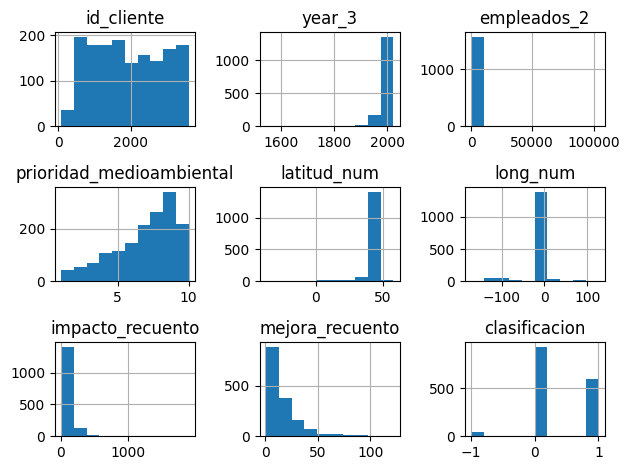

In [163]:
df_clasificado.hist()
plt.tight_layout()

We apply the scaling by consulting with the business, which tells us that since all the entities are located in Aragon, classification by coordinates is discarded

In [243]:
# Prioridad medioambiental reducimos de 10 a 2 tipos
def mapping_prioridad(x):
    if x > 5:
        return 1 # Entidades que NO TIENEN en su top 5 la prioridad mediambiental
    else:
        return 0 # Entidades que lo considerar en su top 5

df_clasificado.loc[:, 'prioridad_medioambiental_map'] = df_clasificado['prioridad_medioambiental'].apply(mapping_prioridad)


In [167]:
# Normalizamos la variable year la reducimos a 4 escalas para simplificar 
def mapping_year(x):
    if pd.isna(x):
        return 3  
    elif x > 2020:
        return 3 
    elif x > 2000:
        return 2
    elif x > 1980: 
        return 1
    else:
        return 0

df_clasificado.loc[:, 'year_map'] = df_clasificado['year_3'].apply(mapping_year)

In [169]:
# Normalizamos la variable empleados:
def mapping_empleados(x):
    if pd.isna(x):
        return 0  
    elif x > 150:
        return 3
    elif x > 50:
        return 2
    elif x > 15:
        return 1
    else:
        return 0

df_clasificado.loc[:, 'empleados_map'] = df_clasificado['empleados_2'].apply(mapping_empleados)

In [171]:
# Normalizamos impacto con el umbral en 150 palabras

def mapping_impacto(x):
    if x > 150:
        return 1
    else:
        return 0

df_clasificado.loc[:, 'impacto_recuento_map'] = df_clasificado['impacto_recuento'].apply(mapping_impacto)

In [173]:
# Normalizamos mejora con el umbral en 25 palabras

def mapping_mejora(x):
    if x > 25:
        return 1
    else:
        return 0

df_clasificado.loc[:, 'mejora_recuento_map'] = df_clasificado['mejora_recuento'].apply(mapping_mejora)

In [174]:
#  Nuestras variables finales:

features_cat = ["tipo_organizacion", "prioridad_medioambiental_map", "clasificacion"]
features_num = ["year_map", "empleados_map","impacto_recuento_map", "mejora_recuento_map"]

Text(0.5, 1.0, 'Variable categórica')

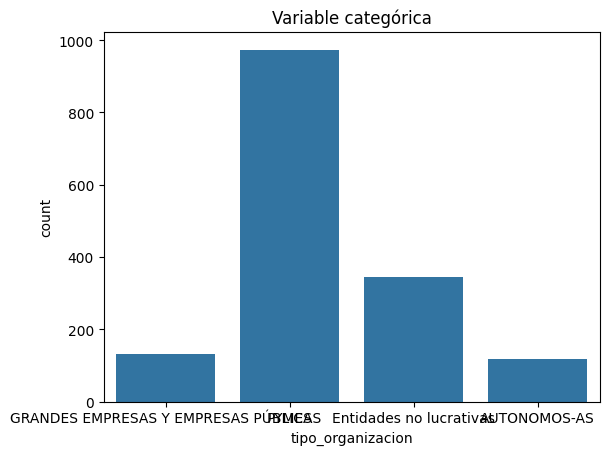

In [175]:
sns.countplot(data=df_clasificado, x="tipo_organizacion")
plt.title("Variable categórica")

Text(0.5, 1.0, 'Variable categórica')

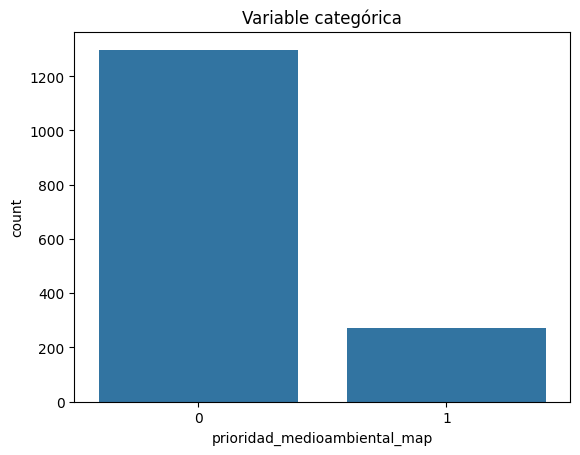

In [236]:
sns.countplot(data=df_clasificado, x="prioridad_medioambiental_map")
plt.title("Variable categórica")

Text(0.5, 1.0, 'Variable categórica')

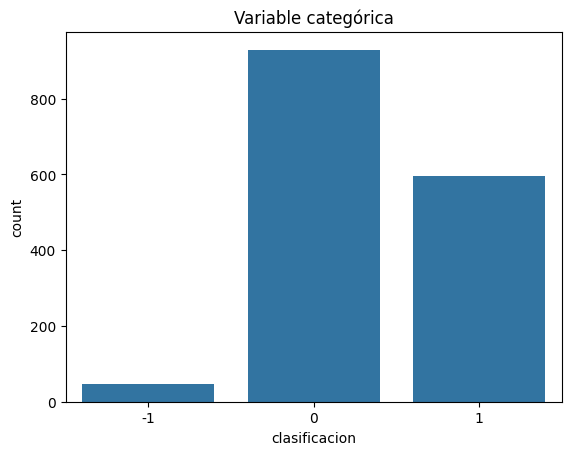

In [177]:
sns.countplot(data=df_clasificado, x="clasificacion")
plt.title("Variable categórica")

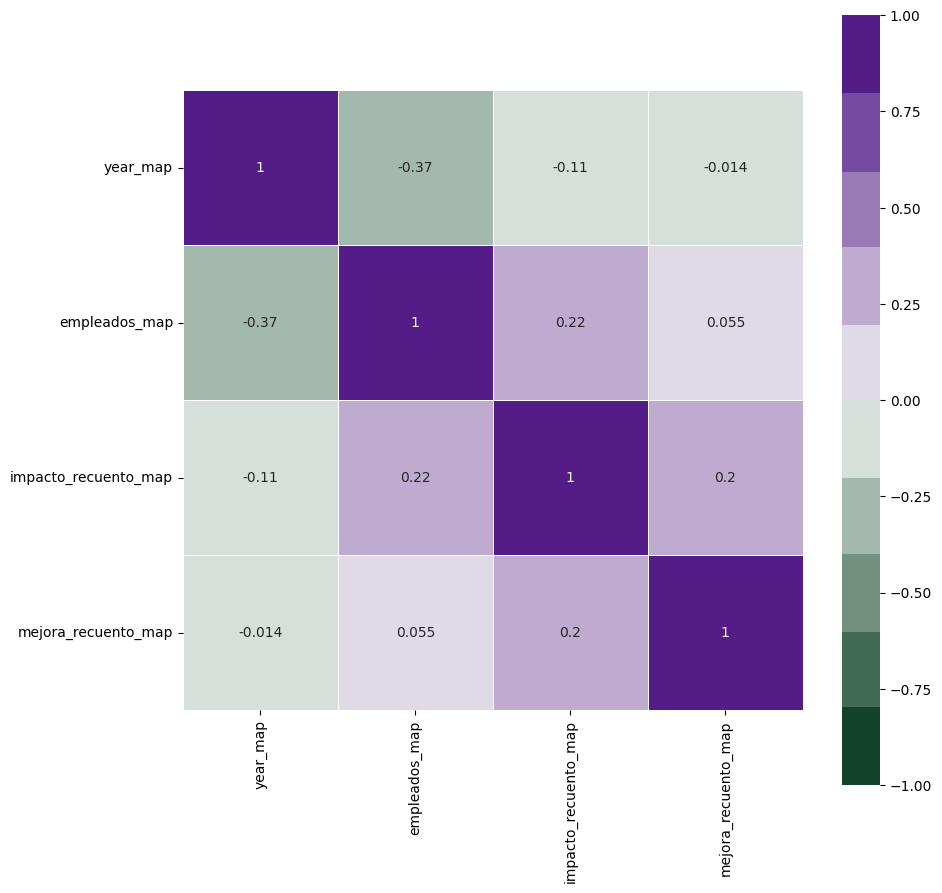

In [244]:
# Establece los límites de colores entre [-1, 1], así como un rango de colores de oscuro a oscuro, pasando por claro (0 correlación)
plt.figure(figsize=(10,10))
sns.heatmap(df_clasificado[features_num].corr(numeric_only=True),
            vmin=-1,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10),
            square=True,
            annot=True,
            linewidths=.5);

#### 7. Solution architecture

In [245]:
train_set = df_clasificado[features_cat+features_num]

Gower distance is useful when working with data sets that include different types of variables, such as categorical, numerical, and ordinal variables. Unlike other distance metrics (such as Euclidean or Manhattan), Gower is designed to handle this type of heterogeneous data efficiently.


In [246]:
# Calcular la matriz de Gower

gower_matrix = gower.gower_matrix(train_set)

C:\Users\josel\AppData\Local\Temp\ipykernel_24452\2386712288.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(gower_matrix, method='average')


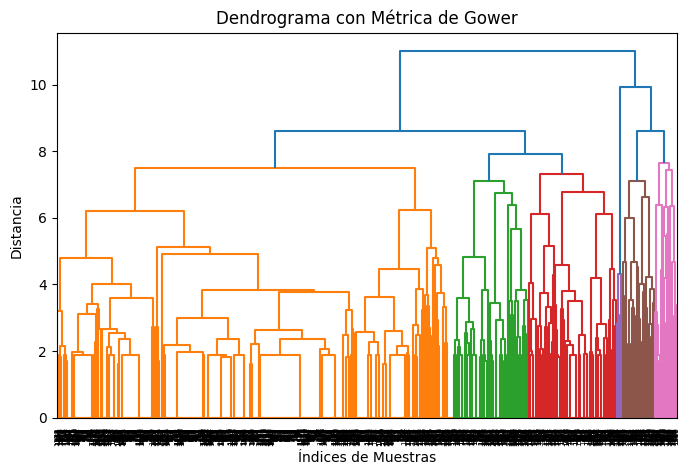

In [247]:
# Generar el enlace jerárquico utilizando la matriz de Gower
linked = linkage(gower_matrix, method='average')

# Crear el dendrograma
plt.figure(figsize=(8, 5))
dendrogram(linked, labels=train_set.index.tolist(), distance_sort='ascending')
plt.title("Dendrograma con Métrica de Gower")
plt.xlabel("Índices de Muestras")
plt.ylabel("Distancia")
plt.show()

We have 6 clusters identified by the model, the next step will be to choose the one requested for Business

In [248]:
# Clustering jerárquico basado en la matriz de distancia de Gower
clusters = linkage(gower_matrix, method='complete')

# Obtener las etiquetas de los clusters 
labels = fcluster(clusters, t=6, criterion='maxclust')

train_set.loc[:, 'Cluster'] = labels


C:\Users\josel\AppData\Local\Temp\ipykernel_24452\2221690740.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(gower_matrix, method='complete')
C:\Users\josel\AppData\Local\Temp\ipykernel_24452\2221690740.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.loc[:, 'Cluster'] = labels


In [249]:
train_set["Cluster"].value_counts()

Cluster
2    800
4    243
3    235
5    126
6    106
1     60
Name: count, dtype: int64

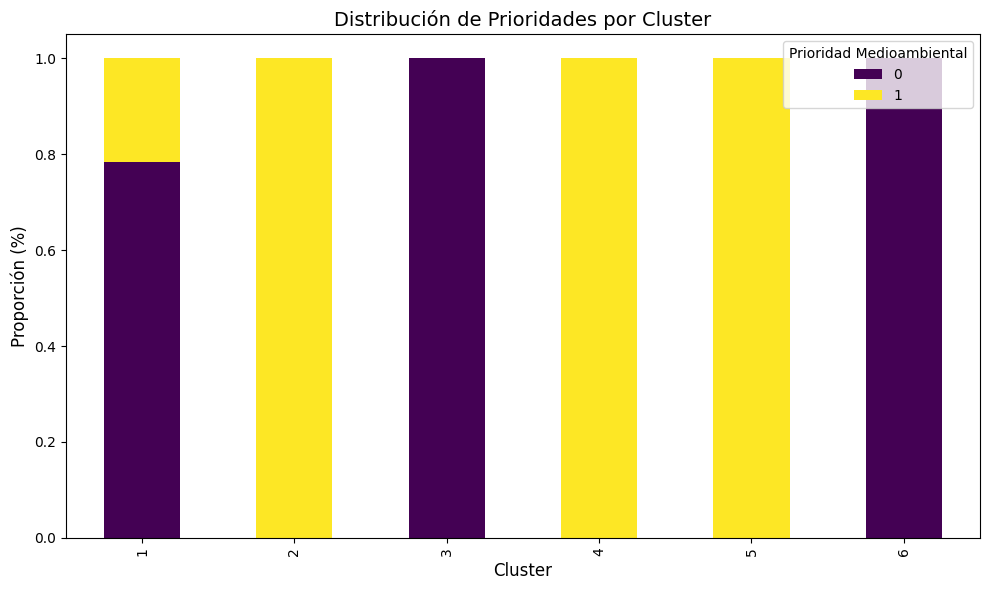

In [250]:
# Calculate the distribution of "prioridad_medioambiental_map" for each cluster
prioridad_por_cluster = train_set.groupby('Cluster')['prioridad_medioambiental_map'].value_counts(normalize=True).unstack()

# Plot the distribution
ax = prioridad_por_cluster.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
ax.set_title('Distribución de Prioridades por Cluster', fontsize=14)
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Proporción (%)', fontsize=12)
ax.legend(title='Prioridad Medioambiental', loc='upper right')
plt.tight_layout()
plt.show()


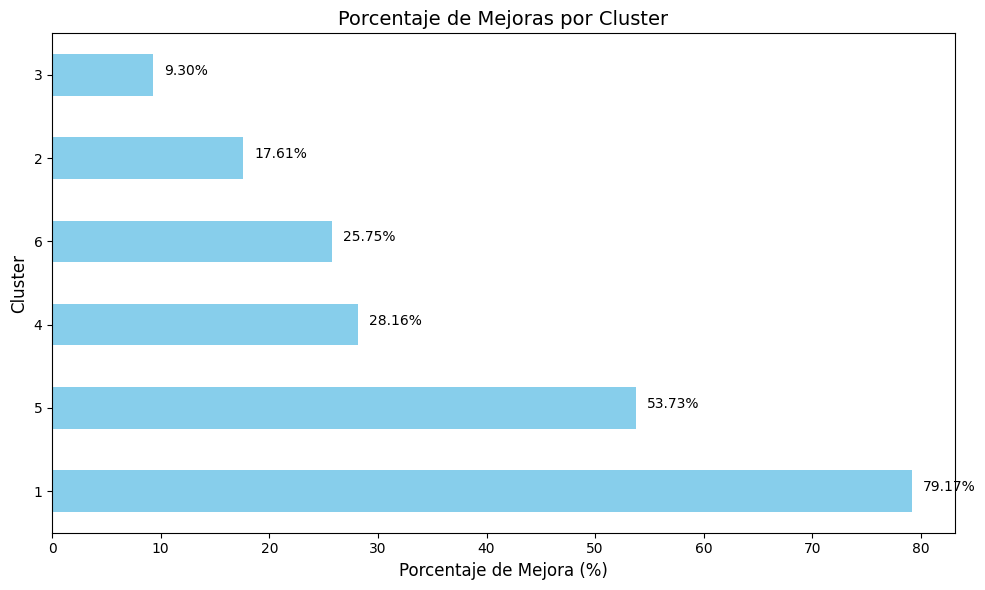

In [186]:
# Calculate the percentage of "mejora_recuento_map" for each cluster
mejoras_por_cluster = train_set.groupby('Cluster')['mejora_recuento_map'].mean() * 100

# Plot the results
ax = mejoras_por_cluster.sort_values(ascending=False).plot(kind='barh', color='skyblue', figsize=(10, 6))
ax.set_title('Porcentaje de Mejoras por Cluster', fontsize=14)
ax.set_xlabel('Porcentaje de Mejora (%)', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
for i, value in enumerate(mejoras_por_cluster.sort_values(ascending=False)):
    ax.text(value + 1, i, f'{value:.2f}%', fontsize=10, color='black')
plt.tight_layout()
plt.show()


We propose our Cluster 6 to Business because these are entities that have the environment among their top five priorities and are clearly interested in improvements, as 25.75% of the entities in this group exceeded the 25-word threshold on their form.

We will send Business the list of the 106 entities with their contact information for the marketing department:

In [251]:
df_cluster = pd.concat([train_set[["Cluster"]],
                            df_clasificado[["id_cliente"]]], axis=1)

In [252]:
df_cluster_6 = df_cluster[df_cluster["Cluster"]==6]
len(df_cluster_6)

106

In [253]:
merged_df = pd.merge(df_cluster_6, df_limpio, on='id_cliente', how='left')
merged_df.sample().T


,59
Cluster,6
id_cliente,3104
id_formulario,9.pdf
tipo_organizacion,Entidades no lucrativas
nombre_organizacion,ASOCIACION ARTRITIS OSCENSE (ARO)
direccion,"C/ Berenguer 2-4,4ª Planta 22002 Huesca"
sector_actividad,Provincia de Huesca
year,2010
empleados,"1 trabajadora social, más los monitores delas distintas actividades físicas, de la salud y\nsociales."
persona_contacto,"Diana Gómez Gil, Trabajadora Social,"


#### 8. Ampliación a supervisado

Once our business cluster has been validated, we are faced with the challenge of leveraging this information to create a model that, based on external company data, can infer whether the company has an environmental priority. In these cases, we do not have any type of survey.

In this case, we propose a model that, based on variables such as organization type, activity classification, year of creation, and number of employees, predicts which company fits into our target cluster.

This can be a useful marketing tool for selecting companies.

In [254]:
# Seleccionamos las variables externas sin mapeo:

df_supervisado = pd.concat([train_set[["tipo_organizacion", "clasificacion", "Cluster"]],
                            df_clasificado[["year_3", "empleados_2"]]], axis=1)

In [255]:
# Simplificamos a nuestro cluster objetivo 6

def mapping_cluster(x):
    if x == 6:
        return 1 # Si es del cluster 6
    else:
        return 0

df_supervisado.loc[:, 'cluster_obj'] = df_supervisado['Cluster'].apply(mapping_cluster)

In [256]:
df_supervisado = df_supervisado.drop(columns= "Cluster")

In [257]:
train, test = train_test_split(df_supervisado, test_size=0.2, random_state=42)

In [258]:
# Definition of the classification problem.

# target_clf → Target variable for classification.
# - It has been previously defined as "cluster_obj".
# - 1 if it is in our cluster 6, 0 otherwise.
# - This is a **binary** classification problem (2 possible categories).

target_clf = "cluster_obj"

y_train_cat = train["cluster_obj"]
y_test_cat = test["cluster_obj"]

In [ ]:
# Definition of the features used in the classification:

# features_cat_clf → Categorical variables
# - Contains only the variable "organization_type" ().
# - Must be transformed with OneHotEncoder to convert it into numeric variables.

# features_num_clf_1 → Numeric variables
# - classification is already normalized: 1 pollutant 0 average -1 ecological
# features_num_clf_2 
# - year_3 will be ordinal encoded and considered categorical
# - employees_2 will be ordinal encoded and considered categorica 


features_cat_clf = ["tipo_organizacion","clasificacion"]
features_num_clf = ["year_3", "empleados_2"]

In [259]:
# Definition of columns to include and exclude in the classification model.

# columns_to_keep_clf → Columns to be kept in the classification model.
# - Includes:
# - features_num_clf_1 (relevant numeric variables).
# - features_cat_clf (categorical variables to be transformed with OneHotEncoder).

# columns_to_exclude_clf → Columns to be excluded from the classification model.
# - Obtained by removing the variables included in columns_to_keep_clf from df.columns.
# - These columns will not be used in the model.

columns_to_keep_clf =  features_num_clf + features_cat_clf

columns_to_exclude_clf = [col for col in train.columns if col not in columns_to_keep_clf] 

columns_to_exclude_clf

['cluster_obj']

In [260]:
# Definition of Pipelines for data preprocessing in classification.

# cat_pipeline → Preprocessing of categorical variables.
# - "Impute_Mode": Imputes missing values ​​using the mode (most frequent value).
# - "OHEncoder": Applies OneHotEncoder, ignoring unknown categories, instead of generating an error.

# logarithmic → Logarithmic transformation of numeric variables.
# - Uses FunctionTransformer with np.log1p to stabilize skewed distributions.
# - feature_names_out="one-to-one" retains the original feature names.

# num_pipeline → Preprocessing of numeric variables.
# - "Impute_Mean": Imputes missing values ​​using the mean.
# - "logarithm": Applies the logarithmic transformation defined above.
# - "SScaler": Applies a StandardScaler to normalize numeric variables.

# imputer_step_cat → ColumnTransformer to apply pipelines based on variable type.
# - "Process_Numeric": Applies a num_pipeline to features_num_clf_1 (numeric variables).
# - "Process_Categorical": Applies a cat_pipeline to features_cat_clf (categorical variables).
# - "Exclude": Removes the columns in columns_to_exclude_clf.
# - remainder="passthrough": Keeps any other columns unchanged.

# pipe_missings_cat → Final pipeline that applies the imputer_step_cat ColumnTransformer.

cat_pipeline = Pipeline(
    [("Impute_Mode", SimpleImputer(strategy="most_frequent")), 
     ("OHEncoder", OneHotEncoder(handle_unknown='ignore'))  
    ]
)
logaritmica = FunctionTransformer(np.log1p, feature_names_out="one-to-one") 
# Convierte las funciones a transformadores
# mapping_empleados_transformer = FunctionTransformer(mapping_empleados)
# mapping_year_transformer = FunctionTransformer(mapping_year)

num_pipeline = Pipeline(
    [("Impute_Mean", SimpleImputer(strategy = "mean")), 
     ("logaritmo", logaritmica),
     ("SScaler", StandardScaler()),
    ]
)

imputer_step_cat = ColumnTransformer(
    [("Process_Numeric", num_pipeline,features_num_clf),
     ("Process_Categorical", cat_pipeline, features_cat_clf), 
     ("Exclude", "drop", columns_to_exclude_clf)],
       remainder = "passthrough"
    )

pipe_missings_cat = Pipeline([("first_stage", imputer_step_cat)])

In [261]:
# Defining Pipelines for Classification Models
#
# - Pipelines are created that combine preprocessing and classification models.
# - Each pipeline first applies `pipe_missings_cat`, which handles missing data and categorical variable encoding.
# - Then, a different classification model is trained in each pipeline:
# - Logistic Regression
# - Random Forest Classifier
# - LGBM Classifier (LightGBM)
#
# - Finally, the models are evaluated with cross-validation using "recall" as a metric.

# Pipeline con Regresión Logística
logistic_pipeline = Pipeline(
    [("Preprocesado", pipe_missings_cat),  # Paso de preprocesamiento
     ("Modelo", LogisticRegression(max_iter=10000, class_weight="balanced"))  
    ])

# Pipeline con RandomForestClassifier
random_pipeline = Pipeline(
    [("Preprocesado", pipe_missings_cat),
     ("Modelo", RandomForestClassifier(class_weight="balanced"))
    ])


# Pipeline con LightGBMClassifier
LGBM_pipeline = Pipeline(
    [("Preprocesado", pipe_missings_cat),
     ("Modelo", LGBMClassifier(verbose=-1, class_weight="balanced"))
    ])

# Evaluación de los modelos con validación cruzada
for name, pipe in zip(["logistic","randomF","LGBM"], 
                      [logistic_pipeline, random_pipeline, LGBM_pipeline]):
    resultado = cross_val_score(pipe, train, y_train_cat, cv=5, scoring="recall", error_score="raise")
    
    # Mostrar el desempeño de cada modelo
    print(f"{name}: {np.mean(resultado):.4f}")
    print(resultado)

logistic: 0.6500
[0.64705882 0.875      0.375      0.82352941 0.52941176]
randomF: 0.0000
[0. 0. 0. 0. 0.]
LGBM: 0.1096
[0.11764706 0.3125     0.         0.05882353 0.05882353]


In [262]:
# Hyperparameter evaluation for classification models with GridSearchCV.
#
# - Different sets of hyperparameters are defined for the models:
# - Logistic Regression (LogisticRegression)
# - Random Forest (RandomForestClassifier)
# - LightGBM (LGBMClassifier)
#
# - GridSearchCV is applied to find the best combination of hyperparameters.
# - Five-way cross-validation (cv=5) is used, with "recall" as the evaluation metric.
# Reason: If your goal is to capture all relevant customers (e.g., customers with a high probability of purchase or retention), it is more important to minimize false negatives.
# This means you will be willing to accept some false positives.
# - Each search is stored in a `pipe_grids_cat` dictionary.

# Definimos sus hiperparametros
reg_log_param = {"Modelo__penalty": [None,"l2"],
                 "Modelo__C": np.logspace(0, 4, 10),
                 "Modelo__class_weight": [None,"balanced"]}

rand_forest_param = {
    'Modelo__n_estimators': [10, 100, 200, 400],
    'Modelo__max_depth': [None,1,2,4,8],
    'Modelo__max_features': ['sqrt', 1, 2, 3],
    'Modelo__class_weight': [None,'balanced']}

param_grid_lgbm = {
    'Modelo__num_leaves': [15, 31, 50],
    'Modelo__learning_rate': [0.01, 0.05, 0.1],
    'Modelo__n_estimators': [50, 100, 200],
    'Modelo__max_depth': [-1,5, 10, 15],
    'Modelo__class_weight': [None,'balanced']}

cv = 5

gs_reg_log = GridSearchCV(logistic_pipeline,
                            reg_log_param,
                            cv=cv,
                            scoring="recall",
                            verbose=1,
                            n_jobs=-1)

gs_rand_forest = GridSearchCV(random_pipeline,
                            rand_forest_param,
                            cv=cv,
                            scoring="recall",
                            verbose=1,
                            n_jobs=-1)

gs_lgb = GridSearchCV(LGBM_pipeline,
                        param_grid_lgbm,
                        cv=cv,
                        scoring="recall",
                        verbose=1,
                        n_jobs=-1)

pipe_grids_cat = {"gs_reg_log":gs_reg_log,
         "gs_rand_forest":gs_rand_forest,
         "gs_lgb":gs_lgb}

In [263]:
# Run GridSearchCV for each classification model.
# 
# - Each hyperparameter search is trained using the training data (df_train, y_train_cat).
# - GridSearchCV will explore all previously defined hyperparameter combinations.
# - Cross-validation is used to evaluate the performance of each combination.
# - The best models will be selected for further use

for nombre, grid_search in pipe_grids_cat.items():
    print(f"Entrenando GridSearch para {nombre}...")  # Mensaje informativo
    grid_search.fit(train, y_train_cat)  # Ajusta el modelo con la búsqueda de hiperparámetros
    print(f"Finalizado: {nombre}")  # Mensaje de finalización
    print(f"Mejores parámetros para {nombre}: {grid_search.best_params_}")  # Imprime los mejores hiperparámetros encontrados
    print(f"Mejor score para {nombre}: {grid_search.best_score_:.4f}")  # Muestra el mejor puntaje obtenido
    print("-" * 50)  # Separador para mayor claridad

Entrenando GridSearch para gs_reg_log...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Finalizado: gs_reg_log
Mejores parámetros para gs_reg_log: {'Modelo__C': 1.0, 'Modelo__class_weight': 'balanced', 'Modelo__penalty': None}
Mejor score para gs_reg_log: 0.6500
--------------------------------------------------
Entrenando GridSearch para gs_rand_forest...
Fitting 5 folds for each of 160 candidates, totalling 800 fits
Finalizado: gs_rand_forest
Mejores parámetros para gs_rand_forest: {'Modelo__class_weight': 'balanced', 'Modelo__max_depth': 1, 'Modelo__max_features': 'sqrt', 'Modelo__n_estimators': 200}
Mejor score para gs_rand_forest: 0.6500
--------------------------------------------------
Entrenando GridSearch para gs_lgb...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Finalizado: gs_lgb
Mejores parámetros para gs_lgb: {'Modelo__class_weight': 'balanced', 'Modelo__learning_rate': 0.01, 'Modelo__max_depth': -1, 'Modelo__n_estimators': 50, 'Modelo__n

In [264]:
#  Evaluating the best classification models
#
# - The best score (best_score_) is extracted from each model after the hyperparameter search.
# - It is stored in a DataFrame for easy comparison.
# - The models are ranked based on their performance, from highest to lowest

best_grids_cat = [(i, j.best_score_) for i, j in pipe_grids_cat.items()]  # Extrae el mejor puntaje de cada modelo

best_grids_cat = pd.DataFrame(best_grids_cat, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)  # Crea un DataFrame ordenado

best_grids_cat  # Muestra los resultados

,Grid,Best score
0,gs_reg_log,0.650000
1,gs_rand_forest,0.650000
2,gs_lgb,0.530882


In [222]:
# Selecting the best classification model
#
# - The best-performing model based on the GridSearchCV evaluation is selected.
# - The first row of the `best_grids_cat` DataFrame, which is already sorted by performance, is used.
# - This model will be stored in the `best_model_cat` variable for later use or saving.
best_model_cat = pipe_grids_cat[best_grids_cat.iloc[0, 0]]  # Extrae el mejor modelo
best_model_cat  # Muestra el modelo seleccionado

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocesado',
                                        Pipeline(steps=[('first_stage',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('Process_Numeric',
                                                                                          Pipeline(steps=[('Impute_Mean',
                                                                                                           SimpleImputer()),
                                                                                                          ('logaritmo',
                                                                                                           FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                               func=<ufunc 'log1p'>)),
                                                                                                          ('SScaler',
                                                                                                           StandardScaler())]),
                                                                                          ['year_3',
                                                                                           'empleado...
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000))]),
             n_jobs=-1,
             param_grid={'Modelo__C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'Modelo__class_weight': [None, 'balanced'],
                         'Modelo__penalty': [None, 'l2']},
             scoring='recall', verbose=1)

In [223]:
# Saving the best classification model in pickle format
#
# - Ensures that the `src/models` directory exists to store the model.
# - Saves the model in a .pkl file for later use.
# - The saved model can be loaded and used without retraining.

# Asegurar que el directorio de modelos exista
os.makedirs('../models', exist_ok=True)

# Guardar el mejor modelo en formato pickle
with open('../models/modelo_pipeline_cat.pkl', 'wb') as archivo:
    pickle.dump(best_model_cat, archivo)  # Guarda el modelo en el archivo

In [224]:
# Recuperamos el modelo de pipelines (version pickle)
with open('../models/modelo_pipeline_cat.pkl', 'rb') as archivo: # ojo read binario
    modelo_pipeline_clf = pickle.load(archivo)

In [225]:
print(classification_report(y_test_cat, modelo_pipeline_clf.predict(test)))

              precision    recall  f1-score   support

           0       0.94      0.57      0.71       291
           1       0.09      0.57      0.16        23

    accuracy                           0.57       314
   macro avg       0.52      0.57      0.43       314
weighted avg       0.88      0.57      0.67       314



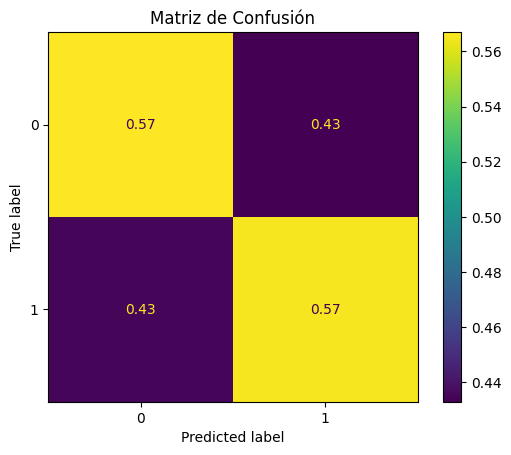

In [226]:
ConfusionMatrixDisplay.from_predictions(y_test_cat, modelo_pipeline_clf.predict(test), normalize = "true")
# ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred)
# Configuración del gráfico
plt.title("Matriz de Confusión")
plt.show()

#### 8. Conclusions and actions for improvement

We have managed to provide the Business department, as requested, with a list of 106 entities that match the profile of our client interested in environmental issues and with areas for improvement. It is a more manageable list compared to the 1,573 entities we initially had.

The final results of the marketing management will be interesting to validate our clustering and take adjustment measures.

Improvement actions: It is recommended to suggest to IAF to unify the types of surveys, restricting fields such as activity, year of creation, and number of employees, as their management becomes complex due to the wide margin left for natural language.

On the other hand, we have created a classification model for other companies different from the 1,573 with the RSA seal, leveraging the clustering. It is an additional tool to focus efforts on one type of entity or another. Thus, we can easily classify entities using 4 variables: organization type, activity classification, number of employees, and year of creation.

The chosen metric was recall since we aim to capture all relevant customers with a potential purchase intention, making it more important to minimize false negatives. This means we are willing to accept some false positives. The model was trained, achieving a recall of 65% in our target class during training and 57% during testing. It is not a highly accurate model due to limited data, but we consider it a reasonable initial model, as it does not indicate overfitting. The model detected 65 out of 100 favorable real cases in training and 57 out of 100 in testing.

Improvement actions: It is recommended to feed the model with more data to improve the metric. Furthermore, it remains a model trained with 1,573 data points within a specific type of entities interested in an RSA seal. It is possible that other types of entities may not show similar purchase behavior.